In [1]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
library(latex2exp)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names

# Data set 1

In [2]:
data_ACC <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

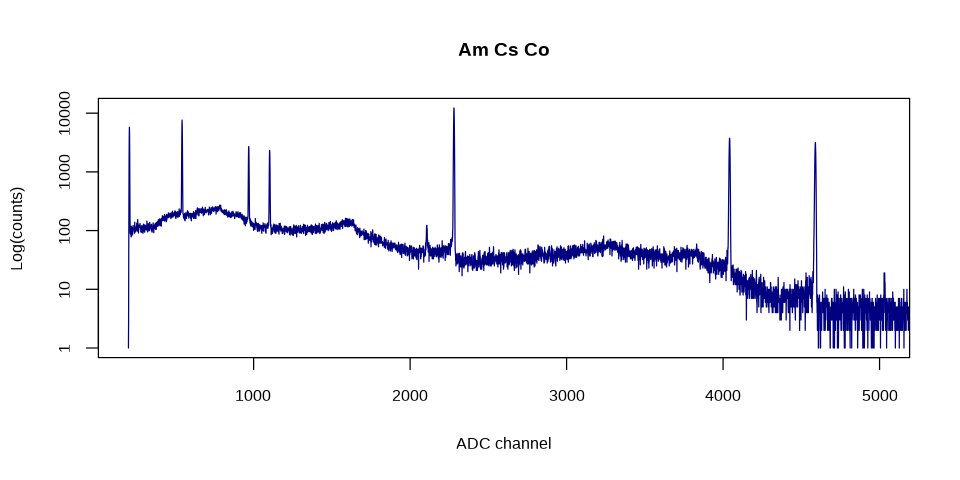

In [3]:
set_plot_dimensions(8, 4)

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [4]:
ACC_energies <-c(59.5409, 661.657, 1173.228, 1332.492,2505.69)
df_ACC <- data.frame(ACC_energies)
row.names(df_ACC)<-c("Am","Cs","Co_1","Co_2","Co_3")
df_ACC


ACC_energies
Am     59.5409   
Cs    661.6570   
Co_1 1173.2280   
Co_2 1332.4920   
Co_3 2505.6900

## Peak detection and characterization

Make sure to check the arguments of ```probe_peaks```

In [5]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}
############ New function ##############
grab_peak <- function(segment, data, peak_width){
    
    #finds the Ch corresponding to the maximum no. of counts
    peak_ch <- filter(segment, counts == max(counts))$Ch
    
    #slices the original dataframe symmetrically around the channel found with filter()
    peak_data <- data[(peak_ch - peak_width%/%2):(peak_ch + peak_width%/%2),]
    return(peak_data)
}


probe_peaks <- function(data, search_width, pk_size, peak_width = 20){

    peaks_list <- NULL
    counter <- 0
    for(i in seq(0, length(data$counts) - search_width, search_width)){
        
        #set up a data segment of (search_width) points to search over
        segment <- data[i:(i + search_width),]
        
        #Convert to log in case the count is too large
        log_counts <- sapply(segment$counts, log)
        
        segment$counts[which(!is.finite(log_counts))] <- 0
        #Check if data segment exceeds threshold
        if(log(range_size(segment$counts) ) < log(pk_size)){
            next
        }
        else{
            counter <- counter + 1
            
            #Make list of data.frame elements
            peaks_list[[counter]] <- grab_peak(segment, data, peak_width)
            #Rename each pair of data.frame columns appended to the list Xcounter and Ycounter
            colnames(peaks_list[[counter]]) <- c(paste('X', counter, sep = ''), paste('Y', counter, sep = ''))
        }
    }
    #bind all columns in the list together into a single dataframe
    centered_peaks <- bind_cols(peaks_list)
    return(centered_peaks)
}
########### New function ###########
convert_to_list <- function(pk_df,n_pk){
    pk_list <- list()
    counter <- 0
    for(i in seq(1, n_pk*2,2)){
        counter <- counter + 1
        t <- NULL
        t$x <- pk_df[[i]][pk_df$Y1!=0]
        t$y <- pk_df[[i+1]][pk_df$Y1!=0]
        pk_list[[counter]] <- t    
    }
    return(pk_list)
}
########### New function ###########
plot_peaks <- function(peaks_df){
    the_plot <- ggplot(data = peaks_df)
    x_vars <- NULL; y_vars <- NULL
    for(name in colnames(peaks_df)){
        if(strsplit(name, '')[[1]][[1]]== 'X'){
            x_vars <- c(x_vars, name)
        }
        else if(strsplit(name, '')[[1]][[1]] == 'Y'){
            y_vars <- c(y_vars, name)
        }
    }
    for(i in seq_along(x_vars)){
        the_plot <- the_plot + geom_line(aes_string(x = x_vars[i],y = y_vars[i]))
    }
    the_plot <- the_plot + xlab('Ch') + ylab('counts')
    return(the_plot)
}


In [6]:
centered_peaks <- probe_peaks(data_ACC, 80, 1000,peak_width =50)


In [7]:
peaks <- convert_to_list(centered_peaks,5)
peaks[[1]]$x <- data_ACC$Ch[203:215]
peaks[[1]]$y <- data_ACC$counts[203:215]

peaks[[5]]$x <- data_ACC$Ch[2075:2125]
peaks[[5]]$y <- data_ACC$counts[2075:2125]

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

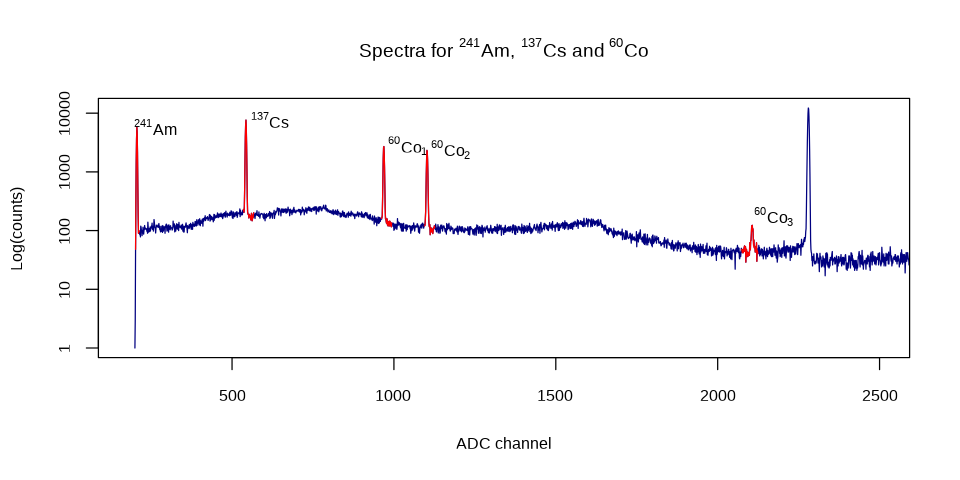

In [8]:
##########
#####PRINT
##########
#Just to control we are picking the right ones
set_plot_dimensions(8,4)
plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    #xlim=c(150,3500),ylim=c(1.e-1,1.e5),
    xlim=c(180,2500),
    main = TeX("Spectra for ^{241}Am, ^{137}Cs and ^{60}Co"),
    ylab = "Log(counts)", xlab ="ADC channel")
names <- c(TeX("^{241}Am"),TeX("^{137}Cs"),TeX("^{60}Co_1"),TeX("^{60}Co_2"),TeX("^{60}Co_3"))

for (i in 1:length(peaks)){
    lines(peaks[[i]]$x,peaks[[i]]$y,col="red")
    text(max(peaks[[i]]$x)+50, max(peaks[[i]]$y)+50, names[i])
}



## Peaks characterization

In [9]:
chain_data <- function(cadena){
    #This function collect the relevant data for each peak from the MC
    #Input a mc from JAGS
    #Output, for each parameter, mean, standard deviation, and 95 % confidence interval.
    
    stat <- summary(cadena)$statistics
    qnt  <- summary(cadena)$quantiles
    mean  <- c(stat[1,1],stat[2,1],stat[3,1],stat[3,1])
    std    <- c(stat[1,2],stat[2,2],stat[3,2],stat[3,2])
    min_95 <- c(qnt[1,1],qnt[2,1],qnt[3,1],qnt[3,1])
    max_95 <- c(qnt[1,5],qnt[2,5],qnt[3,5],qnt[3,5])
    
    results <- data.frame(mean,std,min_95,max_95)
    row.names(results)<-c("A","B","w","x0")
    return(results)
}

In [10]:
#Using JAGS to estimate statistical properties of the peaks
peak_properties <- function (peaks, likelihood_str, priors_str,names){
    #This function is in charge of initializating, running and displaying 
    #the results from the MC produced with JAGS.
    #Input: 
    #      *A list of peak information (x,y)
    #      *A string with the likelihood function to use
    #      *A strin with the priors to use
    #Output:
    #      *The obtained chain for each peak
    #      *The center for each peak and it's standar deviation
    #      *The width of each peak and it's standard deviation
    
    
    i=1
    chains <-c()
    x0_mean <-c()
    x0_std <-c()
    w_mean <-c()
    w_std <-c()


    for (pk in peaks){

        #Plot of the choosen peak
        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y, type="l",
            pch = 1, cex=0.5, col="navy",
            ylab = "Log(counts)", xlab ="ADC channel",
            main=paste("peak",i))

        A.min <- min(pk$y)
        A.max <- max(pk$y)
        B.min <- 0
        B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                             #a stable noise around so min(pk$y) is not representative
        x0.min <- min(pk$x)  
        x0.max <- max(pk$x)

        cat("model{

            #The likelihood: 

",likelihood_str,"

            # Priors for  A, B, x0, w 

",priors_str(A.min,A.max, B.max, x0.min, x0.max),"
}", sep = '', file=paste("Models/model_peak_",i,".bug",sep=""))

        model <- paste("Models/model_peak_",i,".bug",sep="")


        #If multiple chains are run, each of them need to be initialized
        init <- NULL;init$A  <- (A.max-A.min)/2
        init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

        #To have absolute control we also set the seed for and random number generator for each chain
        init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


        chain_number <- 3
        burnin       <- 1000
        iterations   <- 1.e4
        thining      <- 10


        jm <- jags.model(model,
                         pk,
                         inits=init,
                         n.chains=chain_number,
                         quiet=TRUE)

        #Update the Markov chain (Burn-in)
        update(jm, burnin)

        chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
        chains <- append(chains,list(chain))
        #Generate the chain and posterior plots
        options(repr.plot.width = 10, repr.plot.height = 10)
        #plot(chain)
        print(paste("peak",i))
        print(chain_data(chain))

        A  <- summary(chain)$statistics[1]
        B  <- summary(chain)$statistics[2]
        w  <- summary(chain)$statistics[3]
        x0  <- summary(chain)$statistics[4]
        x0_mean <- c(x0_mean,x0)
        x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
        w_mean <- c(w_mean,w)
        w_std  <- c(w_std,summary(chain)$statistics[3,2])

        x <- seq(x0.min,x0.max,0.25)
        f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y,
            ylab = "Counts", xlab ="ADC channel",
            main=names[i])
        lines(x,f, lwd=2, col='firebrick3')
        legend("topright", legend=c("Measurement ", "Fit"),
            col=c("black","firebrick3"), lty=c(0,1),pch=c(1,-1),lwd=c(1,2), cex=0.8)
        i=i+1
    }

    results <- NULL
    results$chains  <- chains
    results$x0_mean <- x0_mean
    results$x0_std  <- x0_std
    results$w_mean  <- w_mean
    results$w_std   <- w_std
        return(results)
}

[1] "peak 1"
          mean          std      min_95      max_95
A  5682.349733 52.389100165 5580.311536 5781.699468
B    86.449258  4.227433159   78.085696   94.641709
w     1.271629  0.008112104    1.255759    1.287556
x0    1.271629  0.008112104    1.255759    1.287556


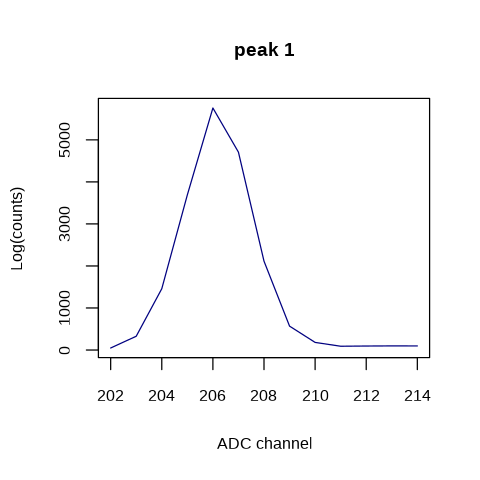

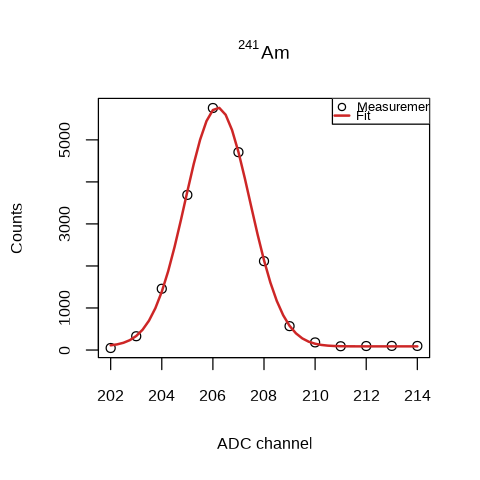

[1] "peak 2"
          mean          std      min_95      max_95
A  7373.641617 55.027802619 7267.768834 7478.682208
B   181.404510  2.843519250  176.000216  186.909304
w     1.548424  0.007849115    1.533463    1.564161
x0    1.548424  0.007849115    1.533463    1.564161


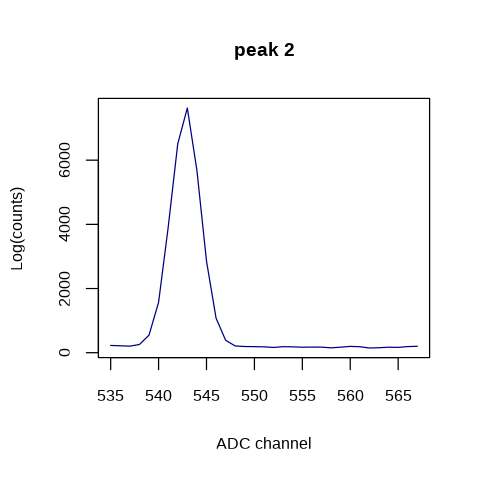

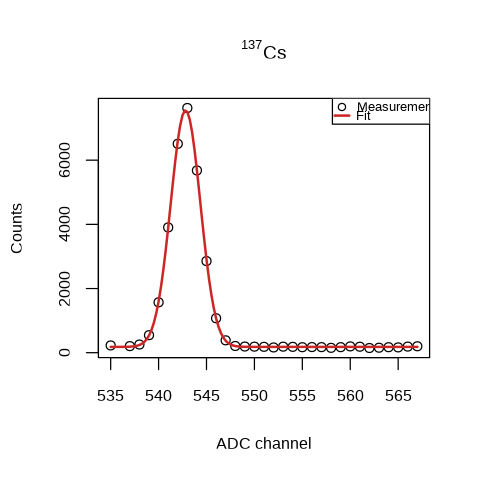

[1] "peak 3"
          mean         std      min_95      max_95
A  2639.717642 33.52546041 2574.536507 2705.751580
B   137.113661  2.50431654  132.276154  141.989828
w     1.668336  0.01547104    1.637211    1.698362
x0    1.668336  0.01547104    1.637211    1.698362


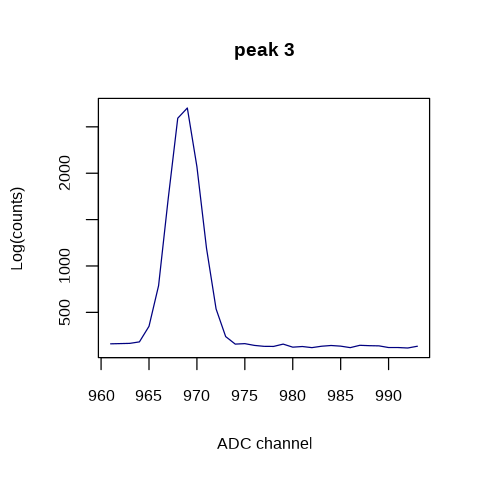

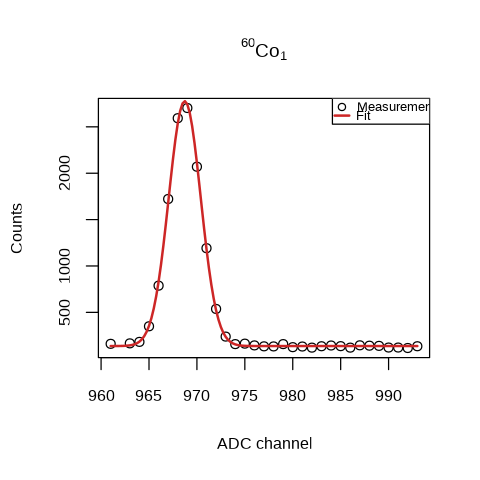

[1] "peak 4"
          mean         std      min_95      max_95
A  2227.178832 29.81049688 2166.734846 2285.604353
B   108.670592  2.26190476  104.279018  113.154738
w     1.779677  0.01737283    1.746454    1.814169
x0    1.779677  0.01737283    1.746454    1.814169


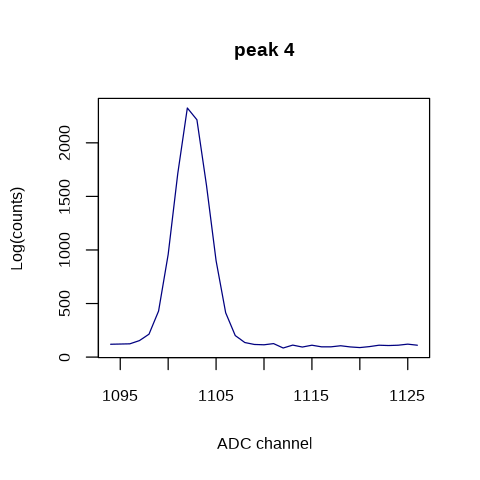

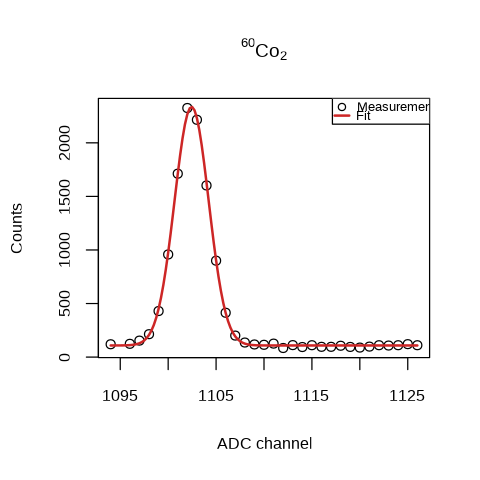

[1] "peak 5"
        mean       std    min_95    max_95
A  76.038362 6.0946586 64.072225 88.291710
B  44.570862 1.1354664 42.400733 46.855233
w   2.771922 0.2415627  2.328772  3.258057
x0  2.771922 0.2415627  2.328772  3.258057


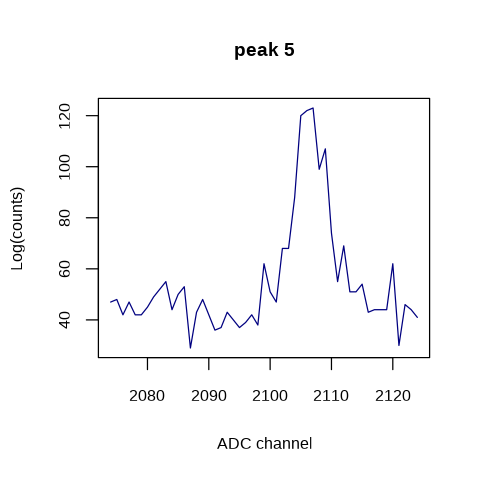

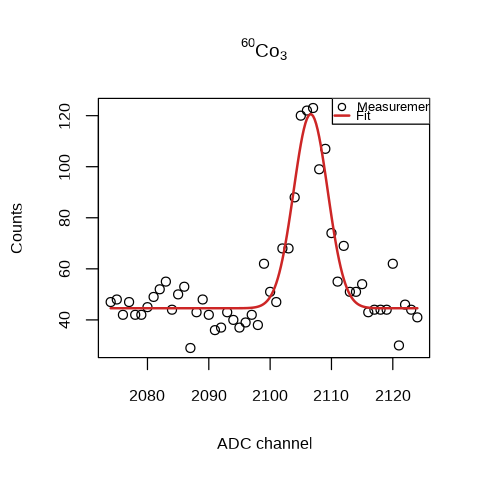

In [11]:
##########
#####PRINT
##########

likelihood_str <- 'for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}'
priors_str <- function(A.min, A.max, B.max, x0.min, x0.max){
    priors_str <- paste("A  ~ dunif(0,50000) #dnorm(",A.max,",",50,")
                         B  ~ dunif(0,50000) #dnorm(",B.max,",",10,")
                         x0 ~ dunif(0,50000) #dunif(",x0.min,",",x0.max,")
                         w  ~ dunif(1,20)", sep = '')
return(priors_str)
}

names <- c(TeX("^{241}Am"),TeX("^{137}Cs"),TeX("^{60}Co_1"),TeX("^{60}Co_2"),TeX("^{60}Co_3"))
ACC_properties <- peak_properties(peaks, likelihood_str, priors_str,names)

#### Americum

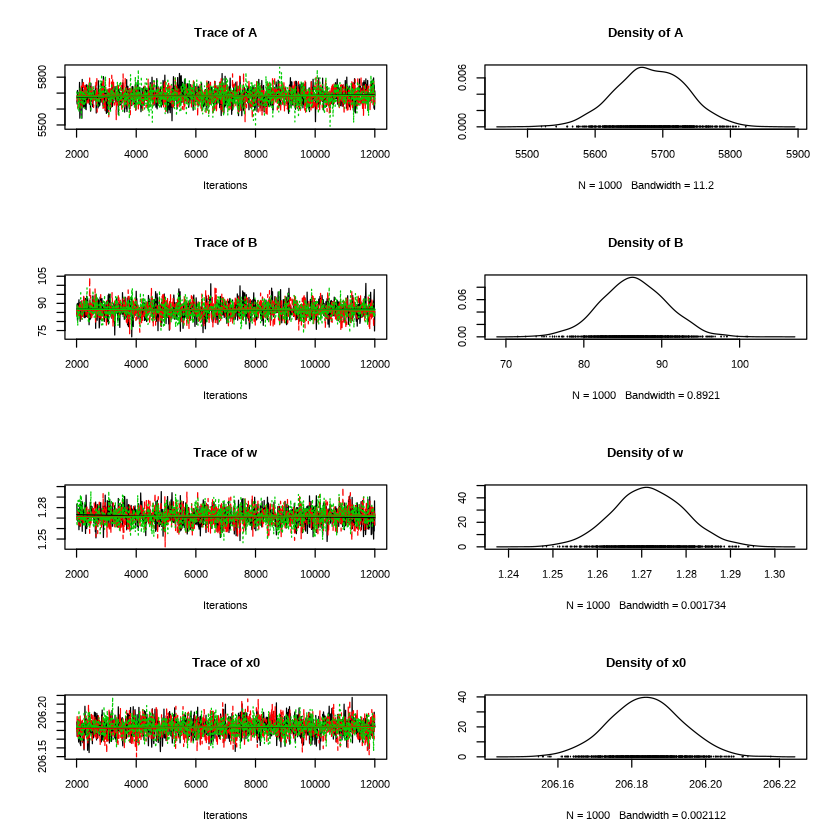

In [12]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[1]])

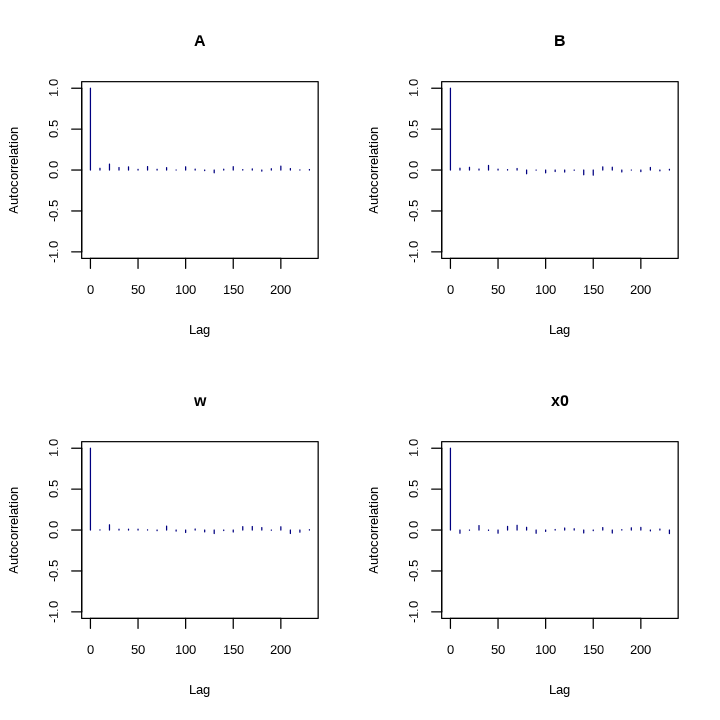

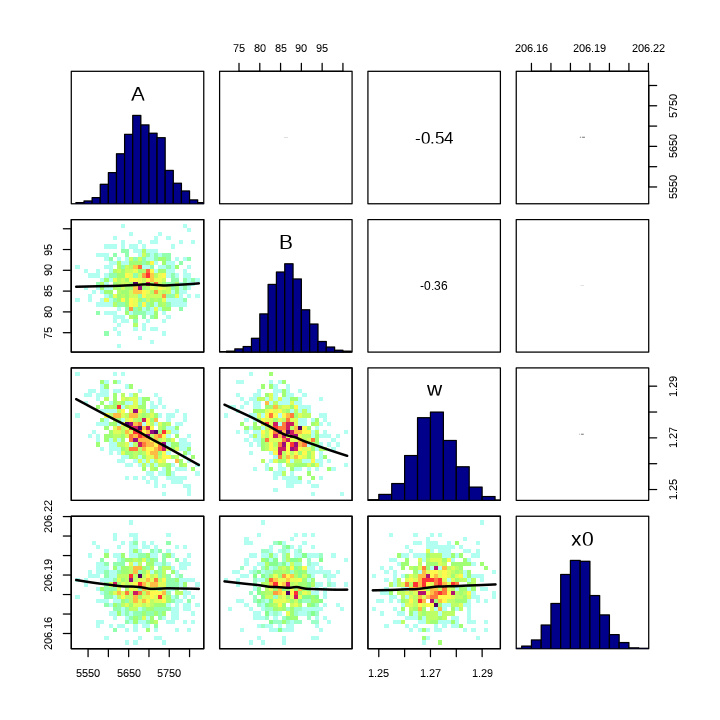

In [13]:
set_plot_dimensions(6, 6)

autocorr.plot(ACC_properties$chains[[1]][1], col='navy')
correlationPlot((ACC_properties$chains[[1]][1]))

#### Cs

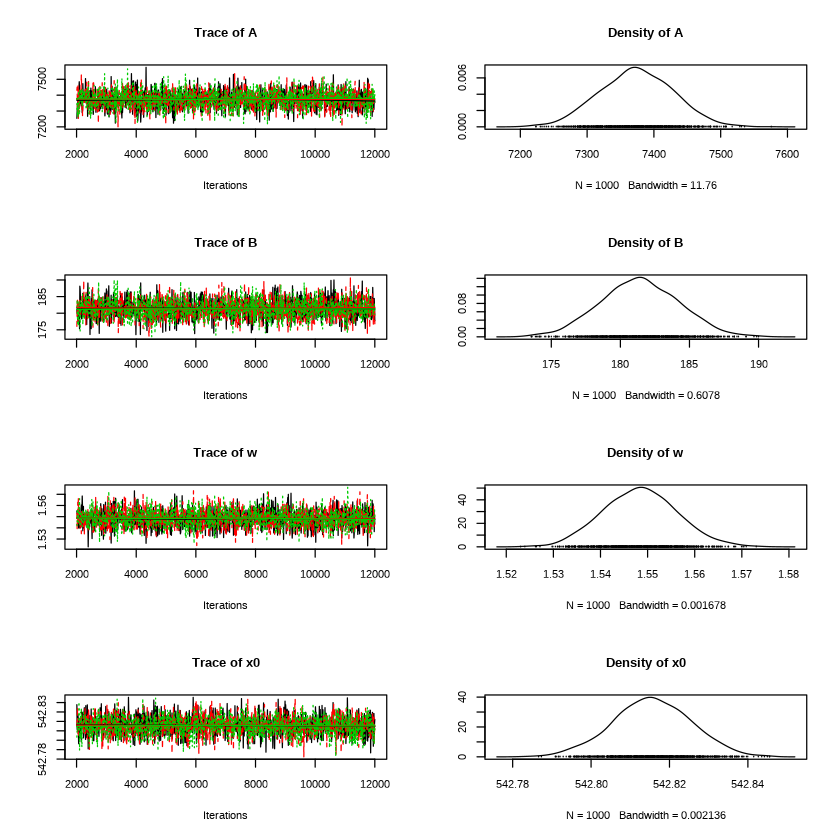

In [14]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[2]])

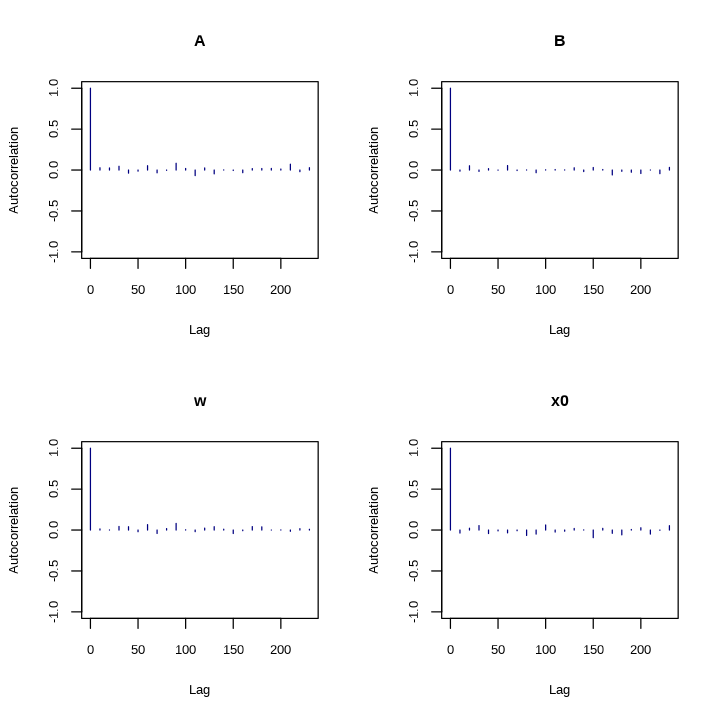

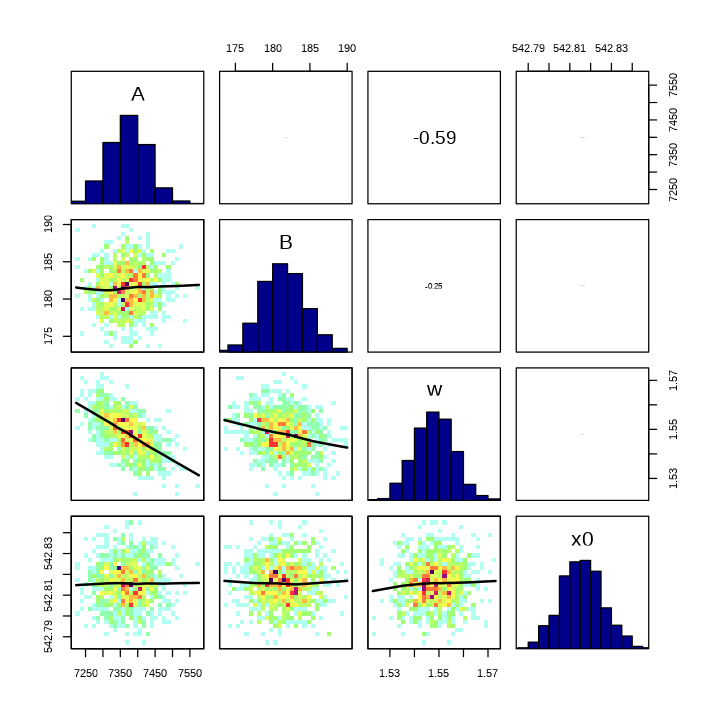

In [15]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[2]][1], col='navy')

correlationPlot((ACC_properties$chains[[2]][1]))

#### Co 1

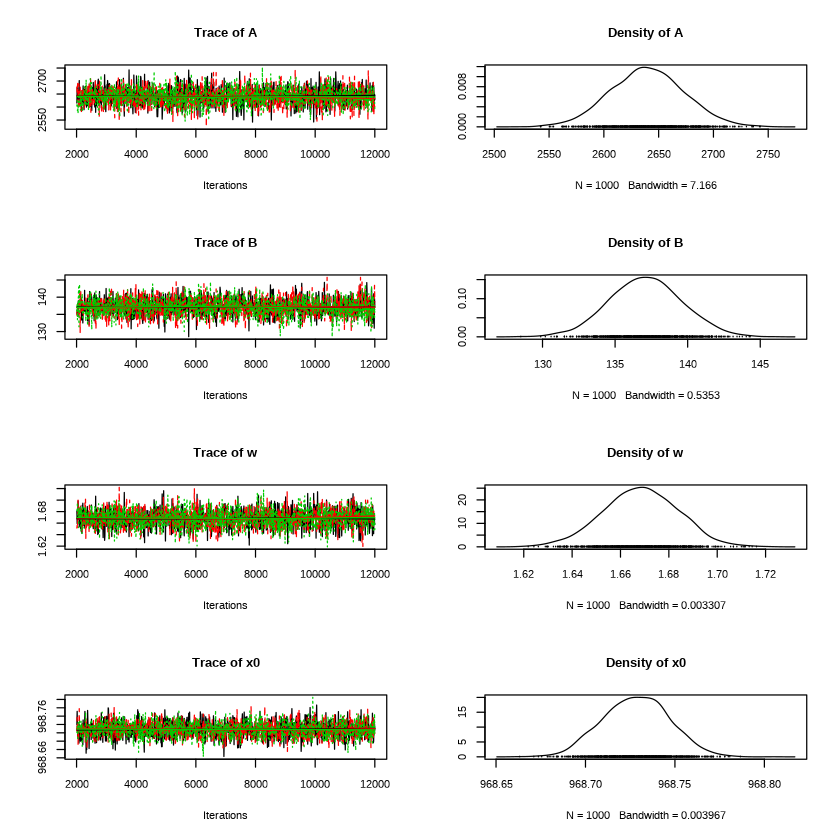

In [16]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[3]])

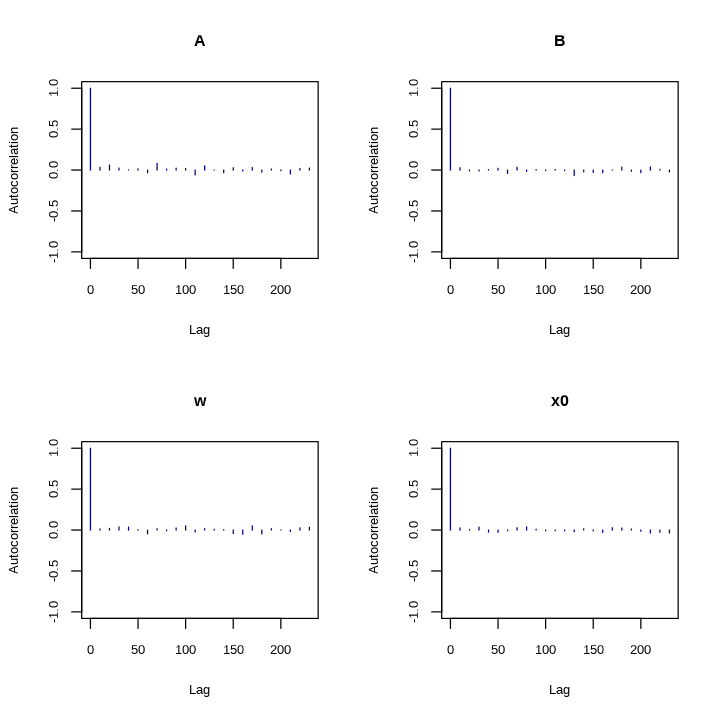

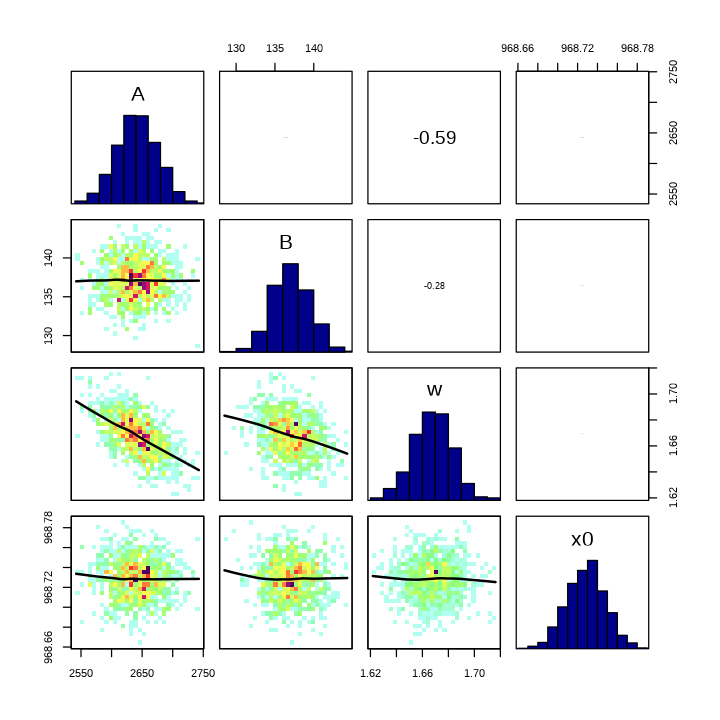

In [17]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[3]][1], col='navy')

correlationPlot((ACC_properties$chains[[3]][1]))

#### Co 2

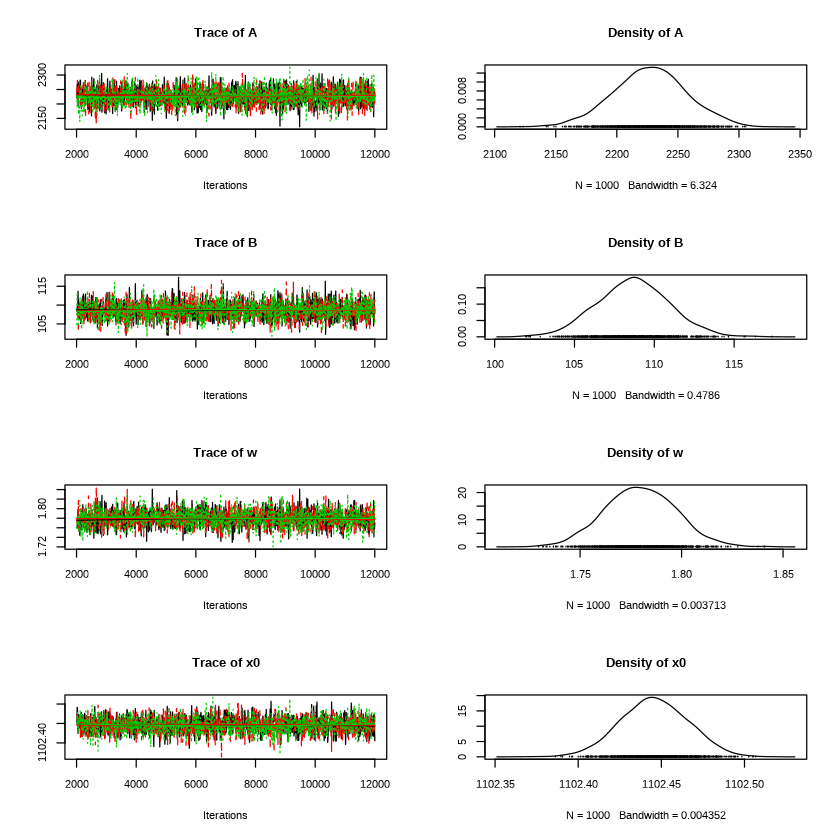

In [18]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[4]])

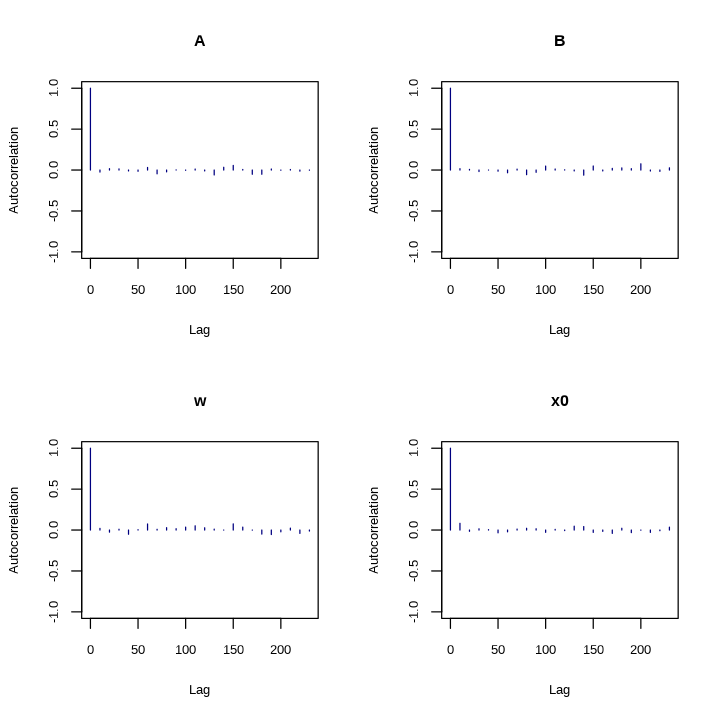

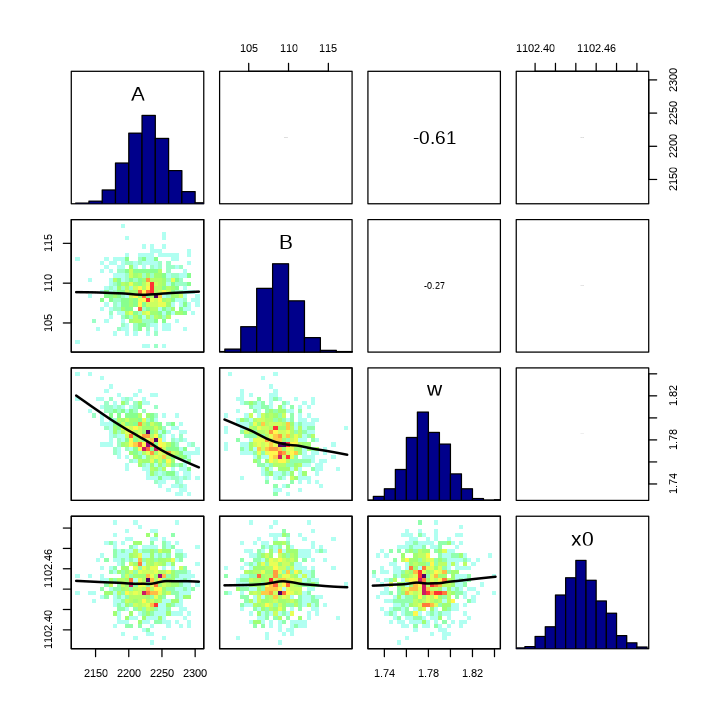

In [19]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[4]][1], col='navy')

correlationPlot((ACC_properties$chains[[4]][1]))

#### Co-3

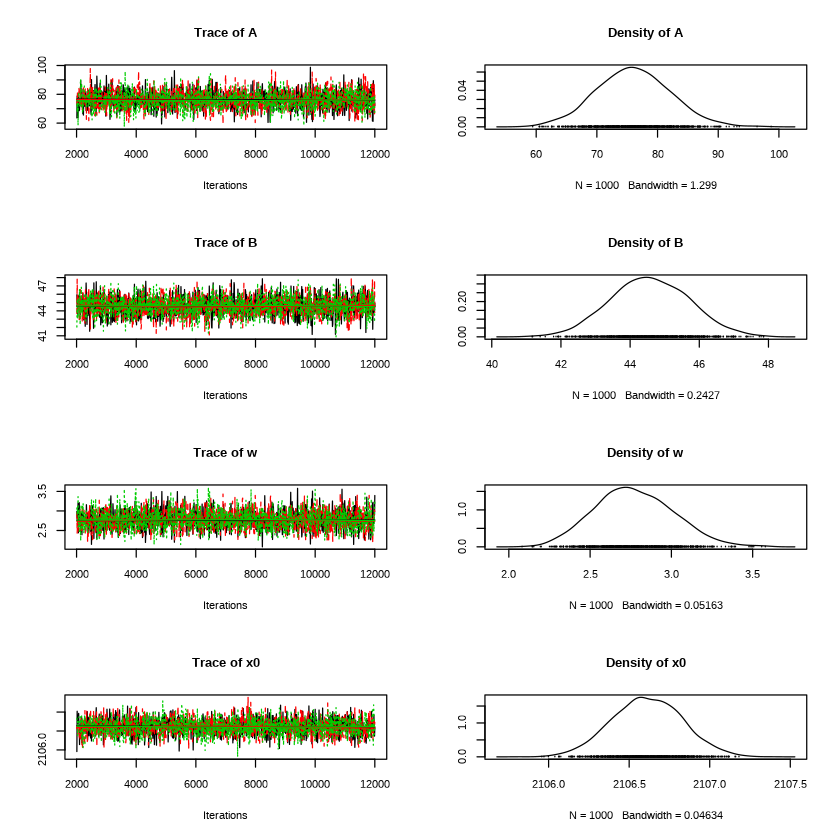

In [20]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[5]])

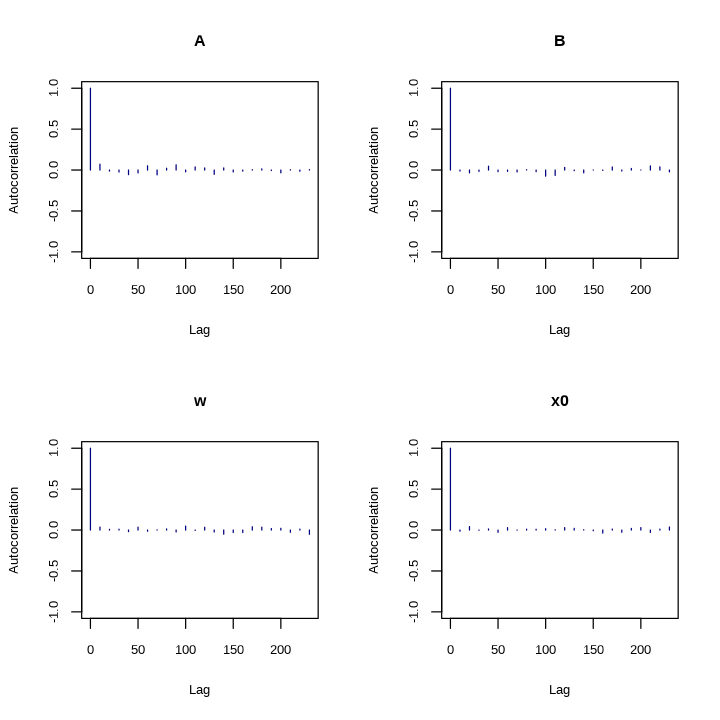

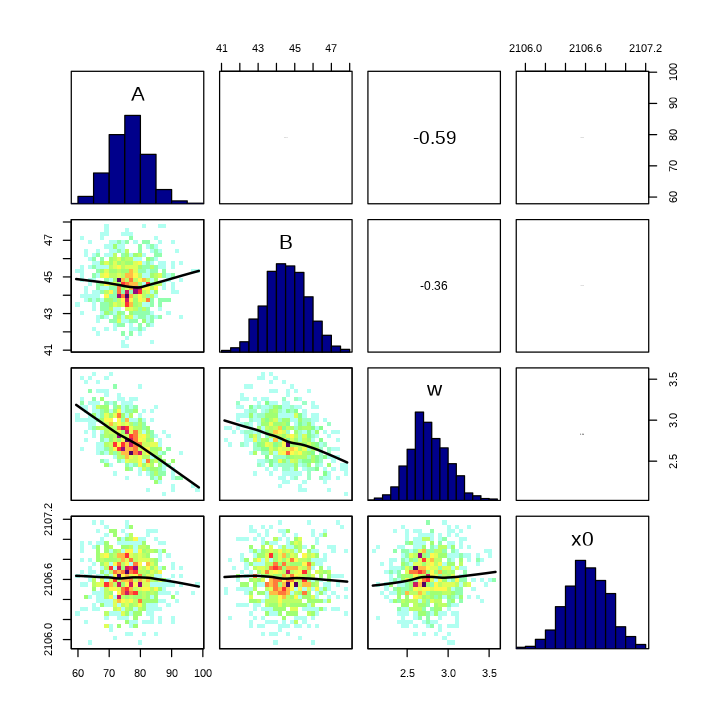

In [21]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[5]][1], col='navy')

correlationPlot((ACC_properties$chains[[5]][1]))

## Energy calibration

To perform the calibration we assume that a linear relation between channels and energy exist, namely:

$$\text{Energy} = a\, \text{ADC channel} + b$$

and use the center of peaks, obtained with the Bayesian parameter estimation, as characteristic position of the peaks.

In [22]:
df_ACC$x0_mean <- ACC_properties$x0_mean
df_ACC$x0_std  <- ACC_properties$x0_std
df_ACC$w_mean  <- ACC_properties$w_mean
df_ACC$w_std   <- ACC_properties$w_std

df_ACC

ACC_energies x0_mean   x0_std      w_mean   w_std      
Am     59.5409     206.1838 0.009882392 1.271629 0.008112104
Cs    661.6570     542.8155 0.009992548 1.548424 0.007849115
Co_1 1173.2280     968.7283 0.018559777 1.668336 0.015471040
Co_2 1332.4920    1102.4458 0.020363106 1.779677 0.017372828
Co_3 2505.6900    2106.6115 0.216824812 2.771922 0.241562742

In [23]:
linear_fit <- lm( df_ACC$ACC_energies[1:5] ~ df_ACC$x0_mean[1:5] )

intercept     <- summary(linear_fit)$coefficients[1,1]
std_intercept <- summary(linear_fit)$coefficients[1,2]
slope         <- summary(linear_fit)$coefficients[2,1]
std_slope     <-  summary(linear_fit)$coefficients[2,2]
                                              
calibrated_energy <- function(x,a,b) a*x+b   #intercept + data_T$Ch*slope

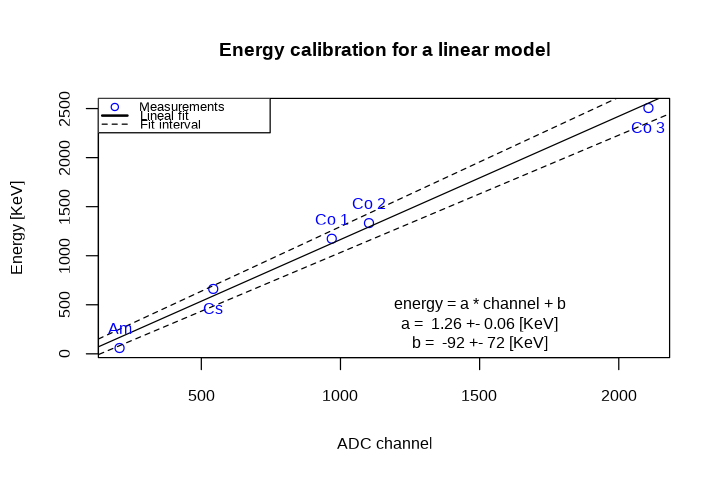

In [24]:
set_plot_dimensions(6, 4)
plot(df_ACC$x0_mean,df_ACC$ACC_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope,intercept))
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope+std_slope,intercept+std_intercept),col="black",lty=2)
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope-std_slope,intercept-std_intercept),col="black",lty=2)

legend("topleft", legend=c("Measurements","Lineal fit","Fit interval"),
       col=c("blue","black","black"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2), cex=0.8)

text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(1500, 500, "energy = a * channel + b")
text(1500, 300, paste("a = ", sprintf("%.2f",slope),"+-",sprintf("%.2f",std_slope),"[KeV]"))
text(1500, 100, paste("b = ", sprintf("%.f",intercept),"+-",sprintf("%.f",std_intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

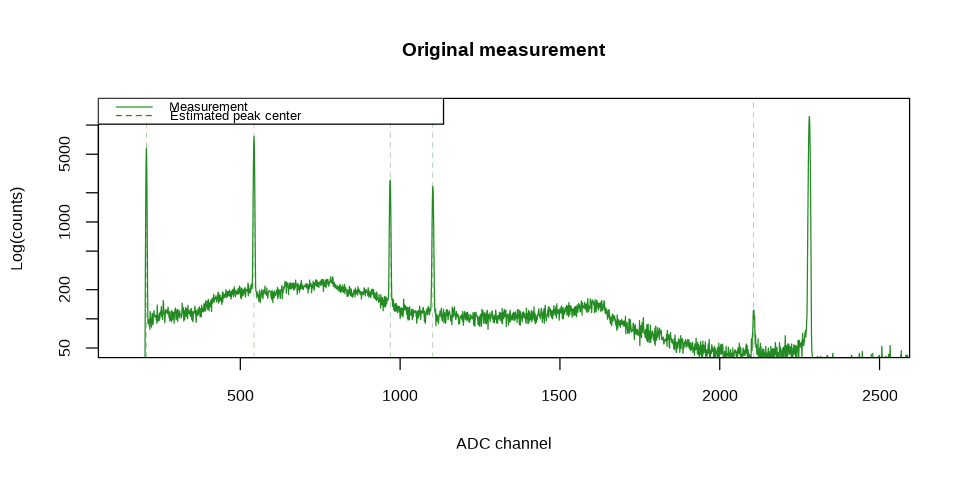

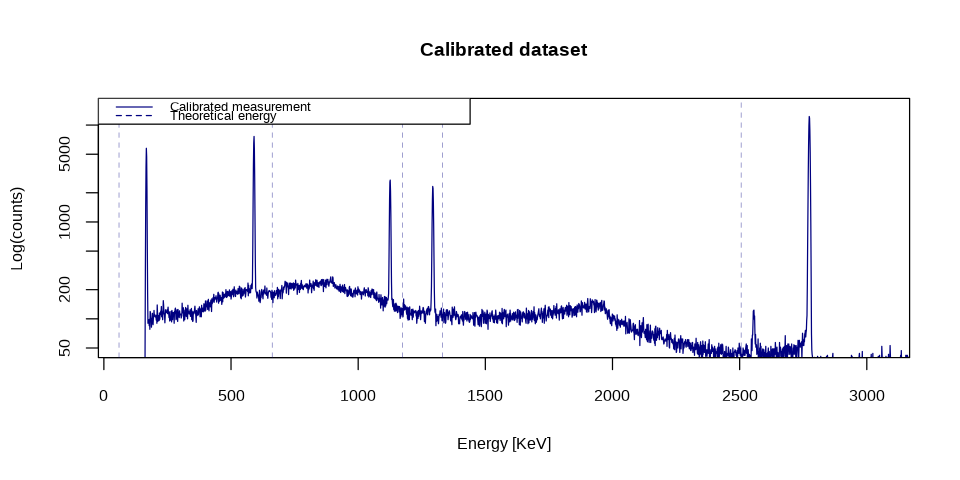

In [25]:
set_plot_dimensions(8, 4)

xmin <- 150;xmax<-2500
ymin <- 50; ymax<-15000
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    ylim=c(ymin,ymax),
    main = "Original measurement",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:5){ abline(v=ACC_properties$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}
legend("topleft", legend=c("Measurement","Estimated peak center"),
       col=c("forestgreen"), lty=1:2, cex=0.8)


plot(calibrated_energy(data_ACC$Ch,slope,intercept),data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    ylim=c(ymin,ymax),
    main = "Calibrated dataset",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:5){
abline(v=df_ACC$ACC_energies[i],col="navy",lty=2,lwd=0.3)}
legend("topleft", legend=c("Calibrated measurement","Theoretical energy"),
       col=c("navy"), lty=1:2, cex=0.8)

## Resolution study

For the resolution study we investigated the relation between the peaks FHWM and the energy of the peaks

In [26]:
#What we obtained from the peaks is w, the standard deviation of a normal distribution,
#this is related to the FWHM as 2*sqrt(2*log(2))*w

#This also needs to be converted to energy units (now is in channels)

df_ACC$FWHM_mean <- (2*sqrt(2*log(2))*ACC_properties$w_mean)*slope
df_ACC$FWHM_std  <- (2*sqrt(2*log(2))*ACC_properties$w_std)*slope

In [27]:
df_ACC

ACC_energies x0_mean   x0_std      w_mean   w_std       FWHM_mean
Am     59.5409     206.1838 0.009882392 1.271629 0.008112104 3.763478 
Cs    661.6570     542.8155 0.009992548 1.548424 0.007849115 4.582671 
Co_1 1173.2280     968.7283 0.018559777 1.668336 0.015471040 4.937561 
Co_2 1332.4920    1102.4458 0.020363106 1.779677 0.017372828 5.267082 
Co_3 2505.6900    2106.6115 0.216824812 2.771922 0.241562742 8.203700 
     FWHM_std  
Am   0.02400835
Cs   0.02323002
Co_1 0.04578765
Co_2 0.05141612
Co_3 0.71492218

In [28]:
df_Resolution_ACC <- NULL
df_Resolution_ACC$x <- df_ACC$ACC_energies
df_Resolution_ACC$y <- df_ACC$FWHM_mean

In [29]:
chain_data_resolution <- function(cadena){
 
    stat <- summary(cadena)$statistics
    qnt  <- summary(cadena)$quantiles
    mean  <- c(stat[2,1],stat[3,1])
    std    <- c(stat[2,2],stat[3,2])
    min_95 <- c(qnt[2,1],qnt[3,1])
    max_95 <- c(qnt[2,5],qnt[3,5])
    
    results <- data.frame(mean,std,min_95,max_95)
    row.names(results)<-c("w","we")
    return(results)
}

In [30]:
resolution <- function(data,likelihood_res,prior_res){
   cat("model{

    #The likelihood:
    ",likelihood_res," 


    # Priors for  
    ",prior_res,"

      
    }", file="Models/ACC_resolution.bug")
    model <- "Models/ACC_resolution.bug" 
    
    init <- NULL
    init$w   <- 3.e-3
    init$we  <- 3;   init$sigma  <- 0.1;#   init$F  <- 0.113
    init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")
    
    chain_number <- 10
    burnin       <- 1000
    iterations   <- 1.e4
    thining      <- 10
    
    jm <- jags.model(model,
                 data,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

    update(jm, burnin)
    
    
    
    chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)
    
    print(chain_data_resolution(chain))
    set_plot_dimensions(8,8)
    plot(chain)
    return(chain)
}

         mean         std    min_95     max_95
w  0.02952756 0.009097279 0.0127297 0.04864667
we 3.04508247 0.934342707 0.8233613 4.62659673


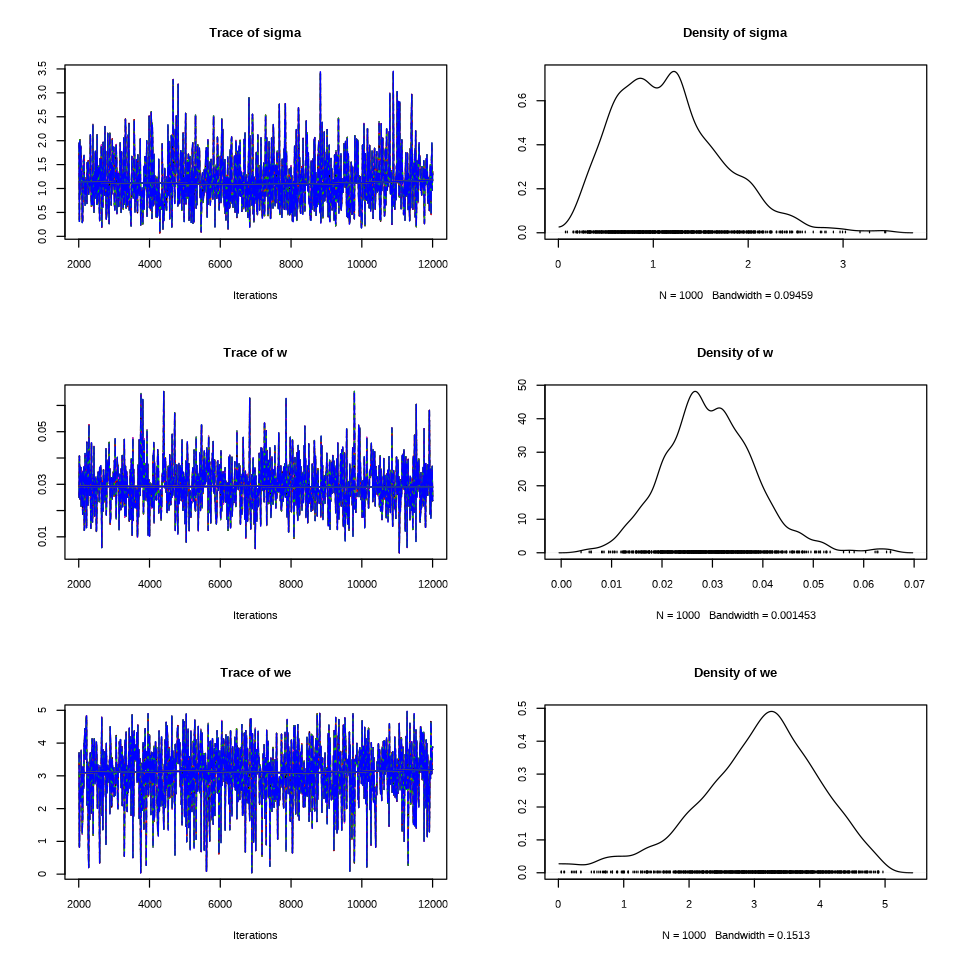

In [31]:
likelihood_res <- " 
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],sigma);
 
    } "
prior_res <-  "w ~ dunif(1.e-3,1);
    we ~ dunif(0,5)#dnorm(3,0.25);
    sigma ~ dnorm(0,1);
    #F ~dnorm(0.113,0.05)"
chain <- resolution(df_Resolution_ACC,likelihood_res,prior_res)

In [32]:
w      <- summary(chain)$statistics[2,1]; sw    <-  summary(chain)$statistics[2,2]
we     <- summary(chain)$statistics[3,1]; swe   <-  summary(chain)$statistics[3,2]
wmin   <- summary(chain)$quantiles[2,1];  wmax  <-  summary(chain)$quantiles[2,5]
wemin  <- summary(chain)$quantiles[3,1];  wemax <-  summary(chain)$quantiles[3,5]
print(paste(w,wmin,wmax))
print(paste(we,wemin,wemax))

[1] "0.0295275589083974 0.0127297016485368 0.0486466745496879"
[1] "3.04508246956067 0.823361335708081 4.62659672616496"


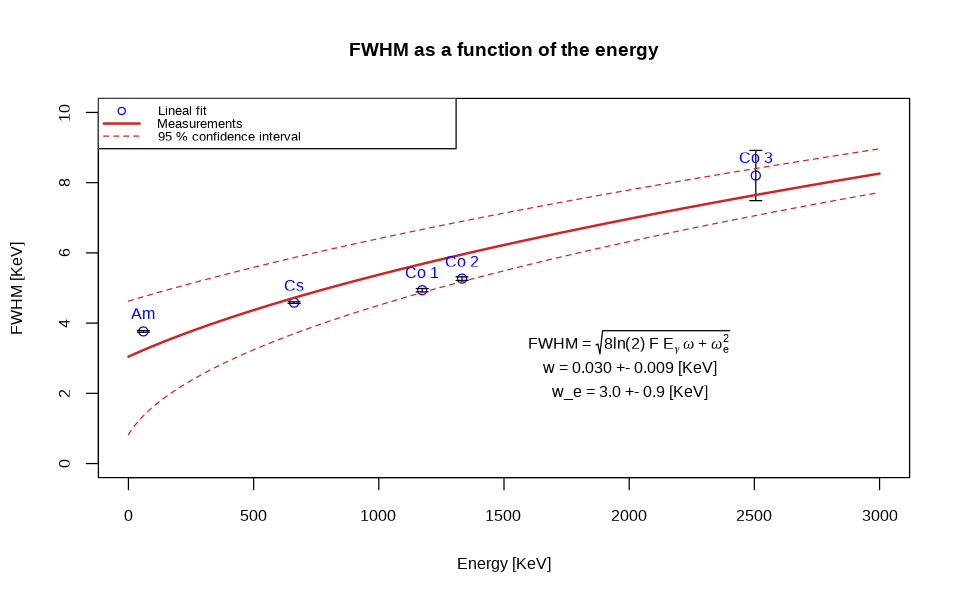

In [33]:
fano <-0.12
    
x <- seq(0,3000,1)
f <- function(x,w,we){return(sqrt(4*2*log(2) * fano * x * w + we**2))}
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 5)
plot(df_ACC$ACC_energies,df_ACC$FWHM_mean,col="blue",
    xlim=c(0,3000), ylim=c(0,10), 
    xlab="Energy [KeV]",ylab="FWHM [KeV]",
    main="FWHM as a function of the energy")

arrows(df_ACC$ACC_energies, df_ACC$FWHM_mean-df_ACC$FWHM_std,
       df_ACC$ACC_energies, df_ACC$FWHM_mean+df_ACC$FWHM_std,
       length=0.05, angle=90, code=3)
lines(x,f(x,w,we), lwd=2, col='firebrick3')
lines(x,f(x,w,wemin), lwd=1,lty=2, col='firebrick3')
lines(x,f(x,w,wemax), lwd=1,lty=2, col='firebrick3')

legend("topleft", legend=c("Lineal fit", "Measurements","95 % confidence interval"),
       col=c("blue","firebrick3","firebrick3"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2,1), cex=0.8)

text(df_ACC$ACC_energies,df_ACC$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2000, 3.5,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2000, 2.7, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2000, 2, paste("w_e =", sprintf("%.1f",we),"+-",sprintf("%.1f",swe),"[KeV]"))

# Dataset 2

In [34]:
data_T <- read.table("data/IC48A_Th.txt", col.names = c('Ch', 'counts')) 

As we don't know which are the peaks to use we cheated, there is a paper from Baudis et.al https://arxiv.org/pdf/1508.05731.pdf with the spectrum from Th in a Germanium detector and there the peaks are identified so we picked two of them which were clearly the same as in our spectrum and used them to "calibrate the energy". We used this information to identify the peaks in our spectrum.

The 511 energy peak is between the channels 3150,3250 centered at 3215

The 2614 energy peak is between the channels 16200,16600 centered at 16450

As the lines we plotted clearly fit existing peaks, we trust that we are picking the correct ones. 

## Visualization

In [35]:
T_energies <-c(238.632,300.089,510.74,583.187,727.330,763.45,785.37,860.53,893.408,1078.63,1512.70,1592.511,1620.738,2103.511,2614.511)
df_T <- data.frame(T_energies)
row.names(df_T)<-c("Pb 1","Pb 2","Tl 1","Tl 2","Bi 1","Tl 3","Bi 2", "Tl 4","Bi 3", "Bi 4", "Bi 5", "Tl 5", "Bi 6", "Tl 6","Tl 7")
df_T

T_energies
Pb 1  238.632  
Pb 2  300.089  
Tl 1  510.740  
Tl 2  583.187  
Bi 1  727.330  
Tl 3  763.450  
Bi 2  785.370  
Tl 4  860.530  
Bi 3  893.408  
Bi 4 1078.630  
Bi 5 1512.700  
Tl 5 1592.511  
Bi 6 1620.738  
Tl 6 2103.511  
Tl 7 2614.511

In [36]:
ch1<-3215;en1<-511
ch2<-16450;en2<-2614
b<-(ch1-ch2)/(en1-en2)
a<-ch1-en1*b
ch_th <- a+ df_T$T_energies *b

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

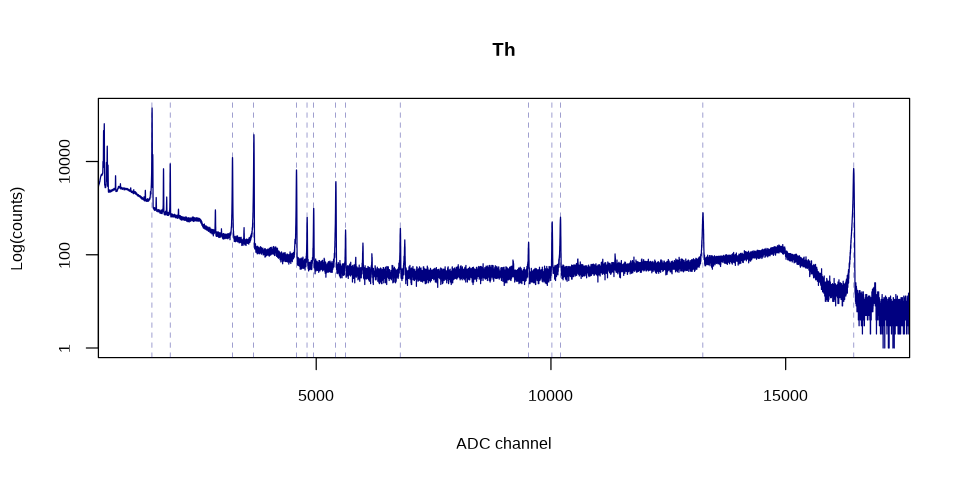

In [37]:
set_plot_dimensions(8, 4)

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){ abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}

## Peak detection and characterization 

In [38]:
 th_1 <- NULL; th_1$x <- data_T$Ch[1450:1550]; th_1$y <- data_T$counts[1450:1550]

 th_2 <- NULL; th_2$x <- data_T$Ch[1850:1950]; th_2$y <- data_T$counts[1850:1950]

 th_3 <- NULL;  th_3$x <- data_T$Ch[3100:3300]; th_3$y <- data_T$counts[3100:3300]

 th_4 <- NULL; th_4$x <- data_T$Ch[3600:3750]; th_4$y <- data_T$counts[3600:3750]

 th_5 <- NULL; th_5$x <- data_T$Ch[4500:4650]; th_5$y <- data_T$counts[4500:4650]

 th_6 <- NULL; th_6$x <- data_T$Ch[4750:4850]; th_6$y <- data_T$counts[4750:4850]

 th_7 <- NULL; th_7$x <- data_T$Ch[4900:5000]; th_7$y <- data_T$counts[4900:5000]

 th_8 <- NULL; th_8$x <- data_T$Ch[5350:5475]; th_8$y <- data_T$counts[5350:5475]

 th_9 <- NULL; th_9$x <- data_T$Ch[5600:5650]; th_9$y <- data_T$counts[5600:5650]

 th_10 <- NULL; th_10$x <- data_T$Ch[6750:6850]; th_10$y <- data_T$counts[6750:6850]

 th_11 <- NULL; th_11$x <- data_T$Ch[9500:9550]; th_11$y <- data_T$counts[9500:9550]

 th_12 <- NULL; th_12$x <- data_T$Ch[10000:10060]; th_12$y <- data_T$counts[10000:10060]

 th_13 <- NULL; th_13$x <- data_T$Ch[10150:10250]; th_13$y <- data_T$counts[10150:10250]

 th_14 <- NULL; th_14$x <- data_T$Ch[13150:13300]; th_14$y <- data_T$counts[13150:13300]

 th_15 <- NULL; th_15$x <- data_T$Ch[16200:16600]; th_15$y <- data_T$counts[16200:16600]


 th_peaks <-list(th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15)

In [39]:
#We must re think how to implement this

#T_peaks <- probe_peaks(data_T, 60, 8000)
#th_peaks <- convert_to_list(T_peaks,10)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

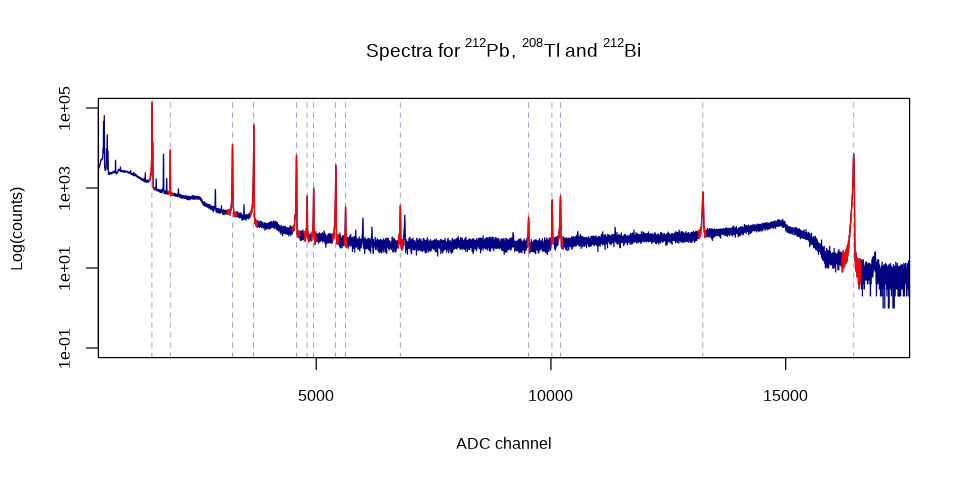

In [40]:
#Just to control we are picking the right ones
plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),ylim=c(1.e-1,1.e5),
    #xlim=c(16000,17000),
    main = TeX("Spectra for ^{212}Pb, ^{208}Tl and ^{212}Bi"),
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}
for (i in 1:length(th_peaks)){lines(th_peaks[[i]]$x,th_peaks[[i]]$y,col="red")}

## Peaks characterization

[1] "peak 1"
           mean         std       min_95       max_95
A  1.403170e+05 0.143474276 140316.71638 1.403173e+05
B  1.523744e+03 0.313760425   1523.11521 1.524333e+03
w  2.704313e+00 0.001938908      2.70065 2.708141e+00
x0 2.704313e+00 0.001938908      2.70065 2.708141e+00


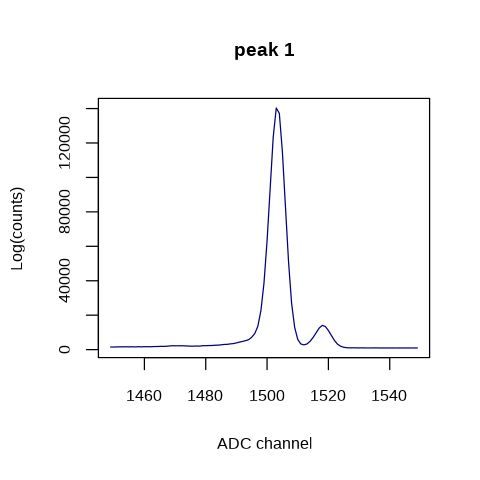

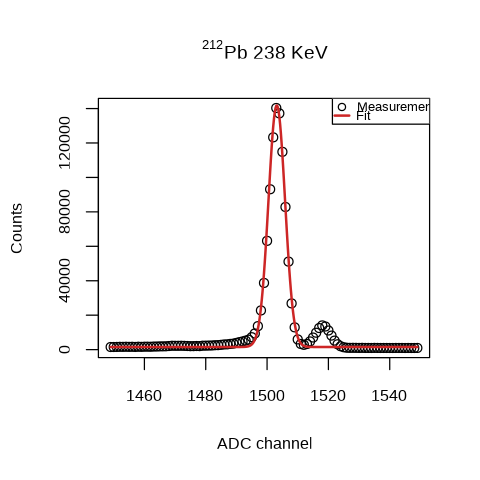

[1] "peak 2"
          mean         std      min_95      max_95
A  8897.991563 0.137440569 8897.722673 8898.273532
B   695.544027 0.303542403  694.940536  696.121816
w     2.755689 0.009396985    2.737535    2.774296
x0    2.755689 0.009396985    2.737535    2.774296


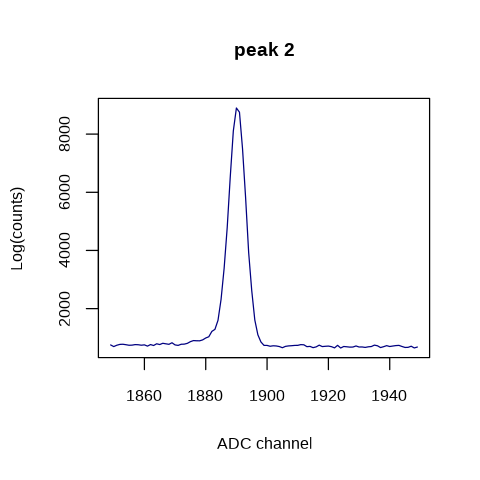

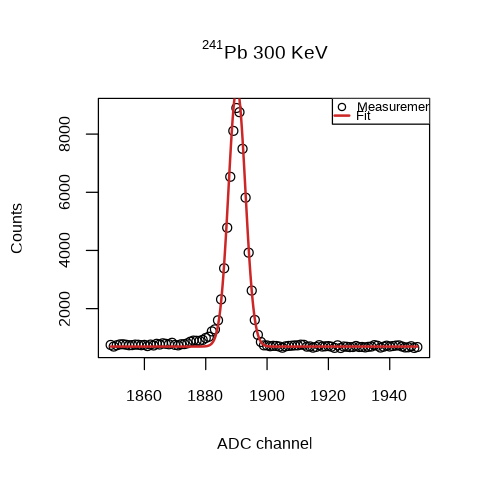

[1] "peak 3"
           mean         std       min_95       max_95
A  12094.982828 0.141114337 12094.702802 12095.254618
B    215.033076 0.301935007   214.461940   215.626604
w      4.097722 0.008928485     4.080121     4.115302
x0     4.097722 0.008928485     4.080121     4.115302


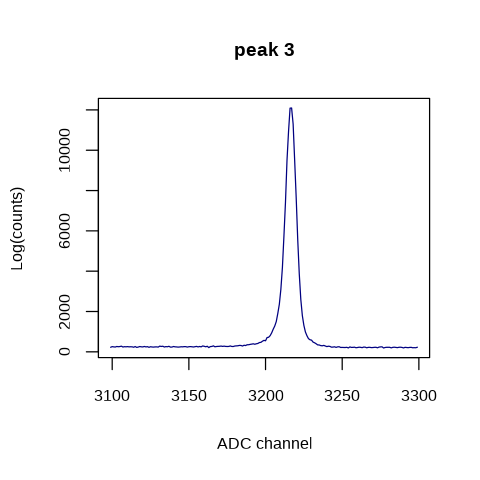

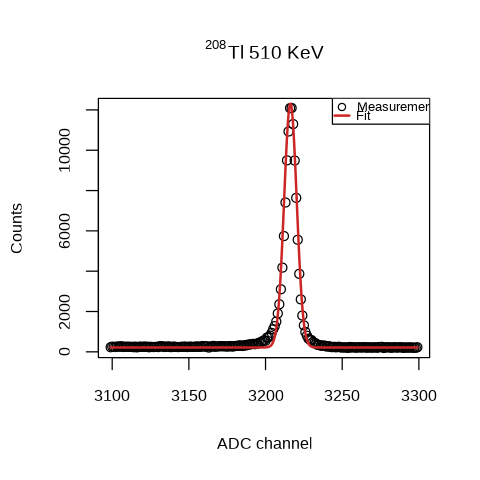

[1] "peak 4"
           mean         std       min_95       max_95
A  37494.992597 0.141965874 37494.704631 37495.259980
B    206.034951 0.305982776   205.440605   206.647718
w      3.928637 0.004509703     3.919876     3.937207
x0     3.928637 0.004509703     3.919876     3.937207


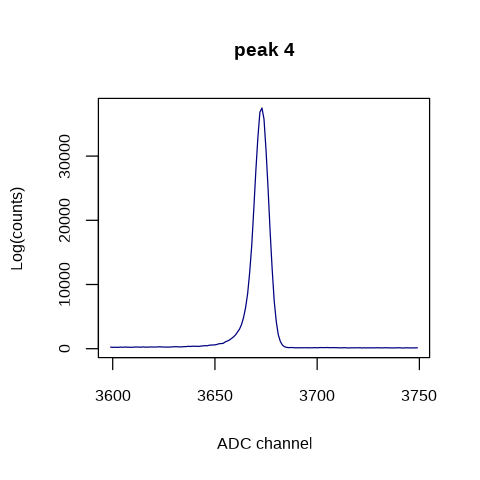

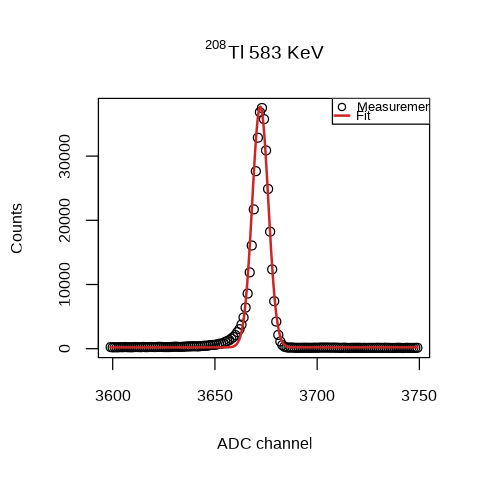

[1] "peak 5"
          mean        std      min_95      max_95
A  6586.985465 0.14070225 6586.712455 6587.268896
B    84.724329 0.29425078   84.152056   85.314711
w     4.352159 0.01155184    4.329765    4.375041
x0    4.352159 0.01155184    4.329765    4.375041


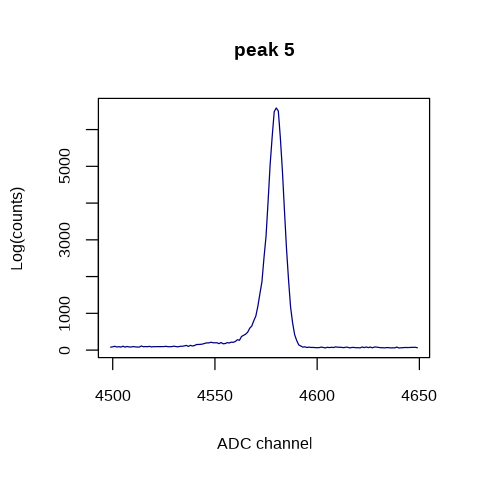

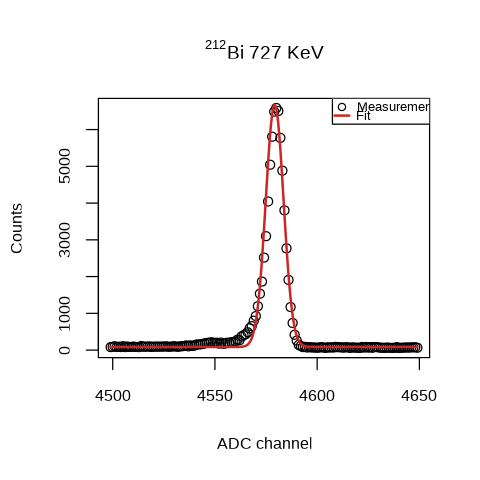

[1] "peak 6"
        mean        std     min_95     max_95
A  629.98434 0.13989803 629.705272 630.252640
B   49.58773 0.28790629  49.036979  50.168175
w    4.45015 0.04813741   4.357195   4.545852
x0   4.45015 0.04813741   4.357195   4.545852


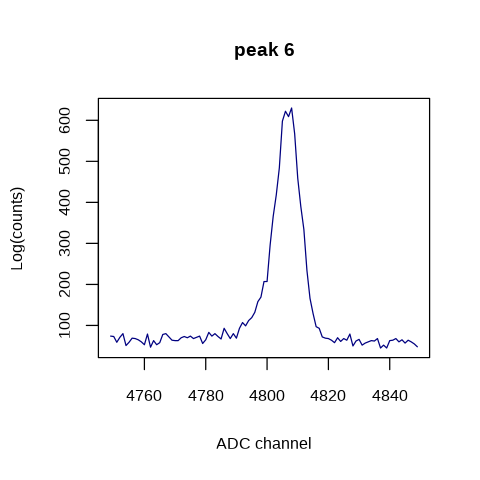

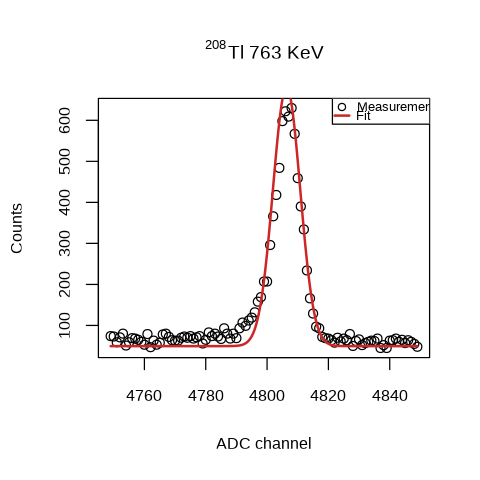

[1] "peak 7"
         mean        std     min_95     max_95
A  989.991804 0.13945741 989.723379 990.263739
B   50.362735 0.28674615  49.808054  50.926077
w    4.449739 0.03606761   4.378653   4.519878
x0   4.449739 0.03606761   4.378653   4.519878


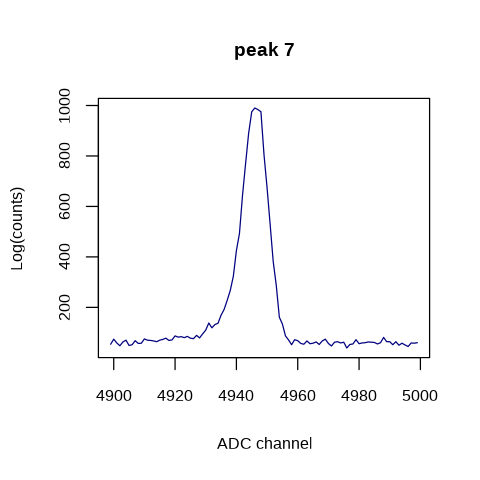

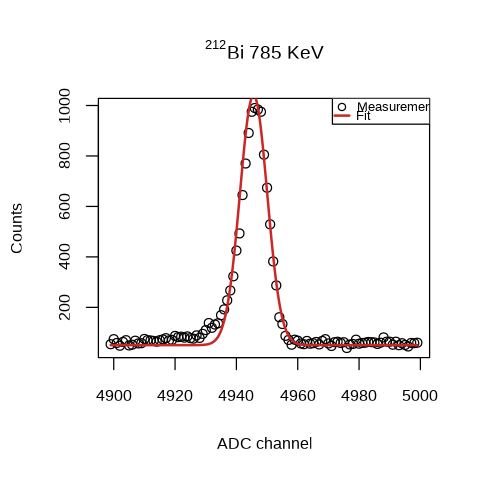

[1] "peak 8"
          mean        std      min_95     max_95
A  3693.984706 0.14099883 3693.701346 3694.25950
B    52.859381 0.27632270   52.328964   53.39440
w     4.771975 0.01692611    4.739319    4.80455
x0    4.771975 0.01692611    4.739319    4.80455


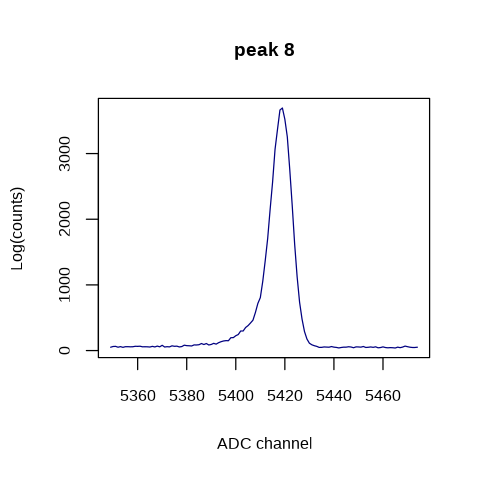

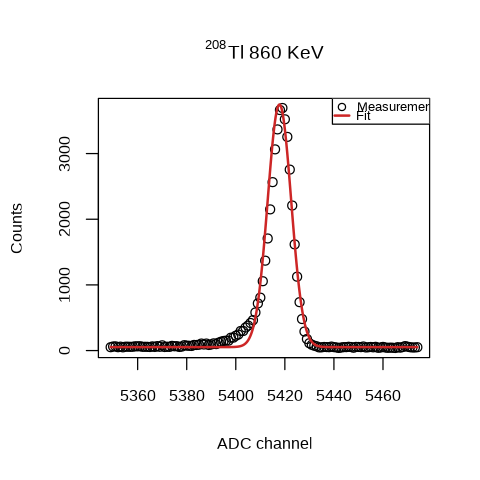

[1] "peak 9"
         mean       std    min_95     max_95
A  339.974187 0.1453510 339.69452 340.265708
B   37.867491 0.3065645  37.27068  38.484539
w    4.446919 0.0727574   4.30798   4.587054
x0   4.446919 0.0727574   4.30798   4.587054


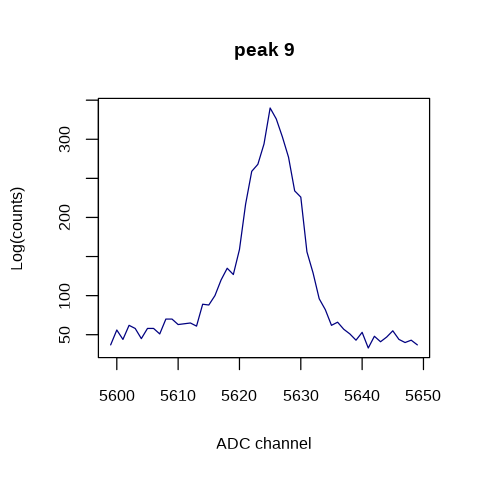

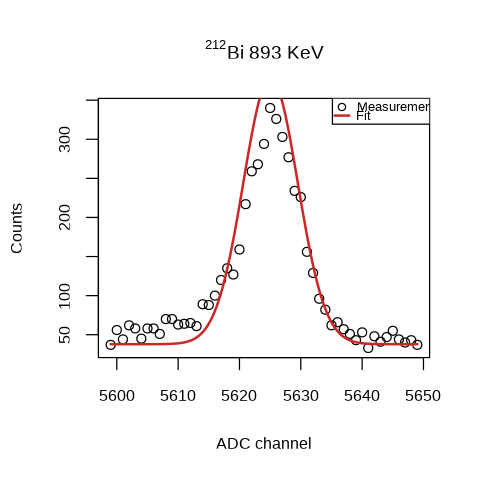

[1] "peak 10"
         mean       std    min_95     max_95
A  368.975737 0.1418906 368.69619 369.247281
B   34.954342 0.2818560  34.41056  35.530309
w    4.910911 0.0690749   4.77895   5.048713
x0   4.910911 0.0690749   4.77895   5.048713


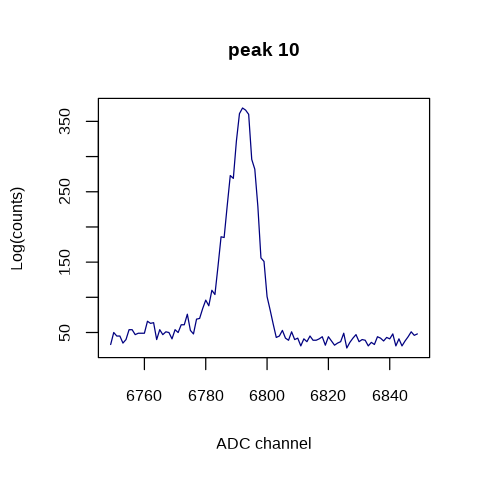

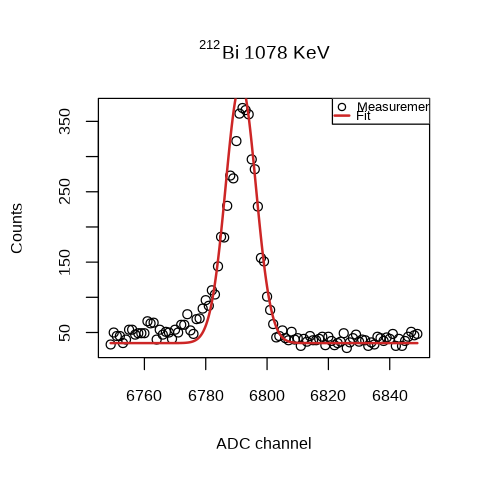

[1] "peak 11"
         mean       std    min_95     max_95
A  185.963878 0.1393503 185.68609 186.244003
B   34.517797 0.3066766  33.94064  35.110344
w    5.465889 0.1288768   5.22137   5.718148
x0   5.465889 0.1288768   5.22137   5.718148


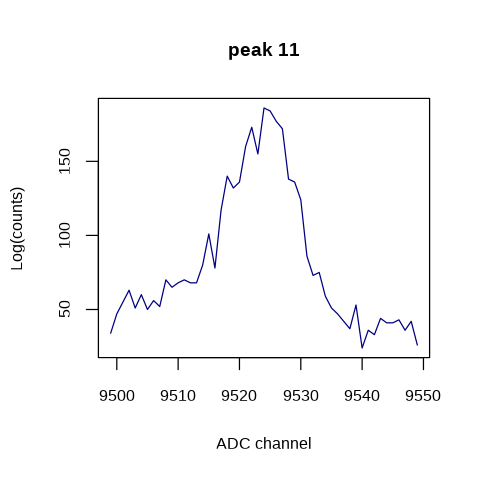

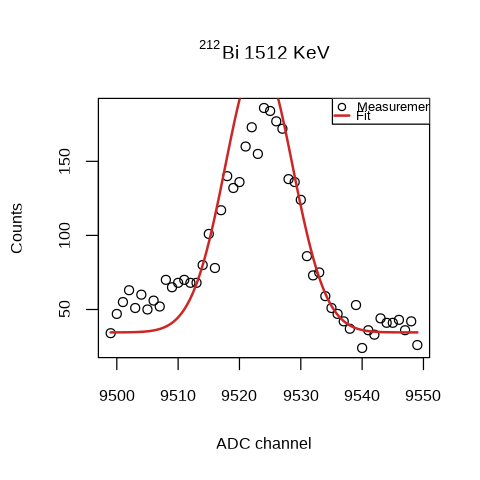

[1] "peak 12"
         mean        std    min_95     max_95
A  505.980740 0.13937900 505.71423 506.260185
B   40.469853 0.31503992  39.86331  41.086355
w    5.131247 0.05348334   5.03023   5.236061
x0   5.131247 0.05348334   5.03023   5.236061


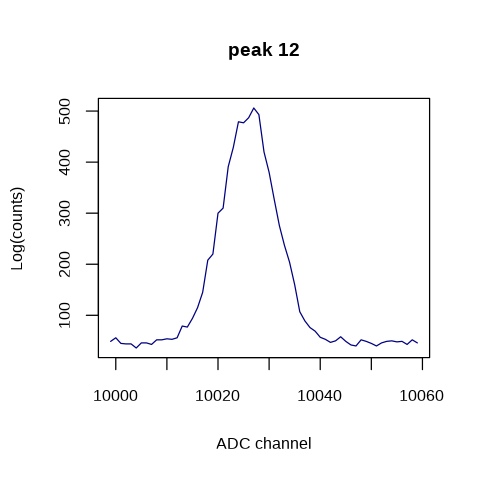

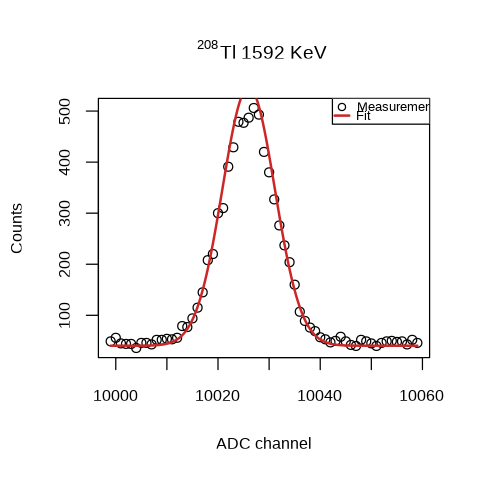

[1] "peak 13"
         mean        std     min_95     max_95
A  638.972608 0.14040803 638.706618 639.250409
B   45.595985 0.29486631  45.032931  46.176302
w    6.059664 0.05507225   5.954097   6.167464
x0   6.059664 0.05507225   5.954097   6.167464


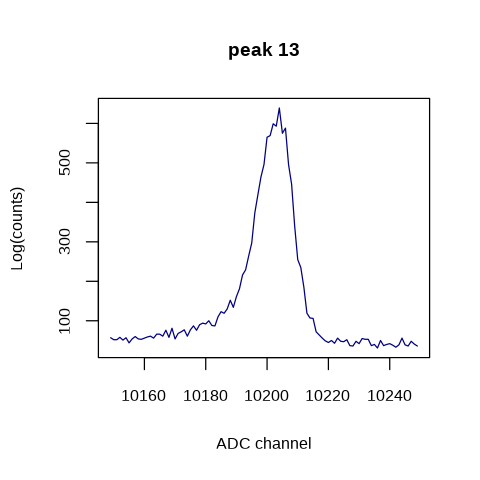

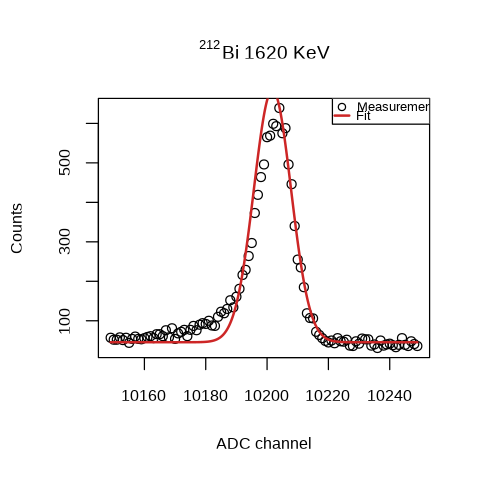

[1] "peak 14"
        mean        std     min_95     max_95
A  796.93995 0.14246927 796.666902 797.218711
B   60.77720 0.28517657  60.231251  61.332971
w    9.86051 0.06219045   9.730799   9.975727
x0   9.86051 0.06219045   9.730799   9.975727


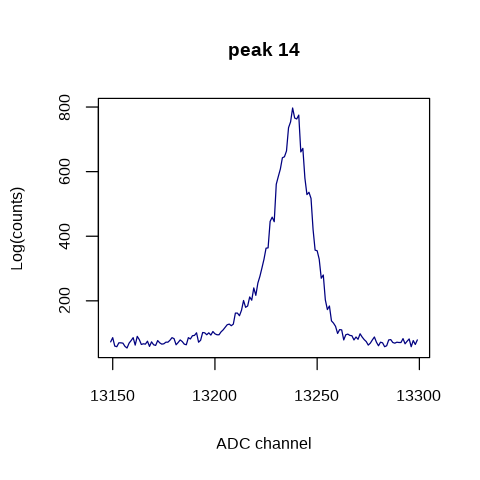

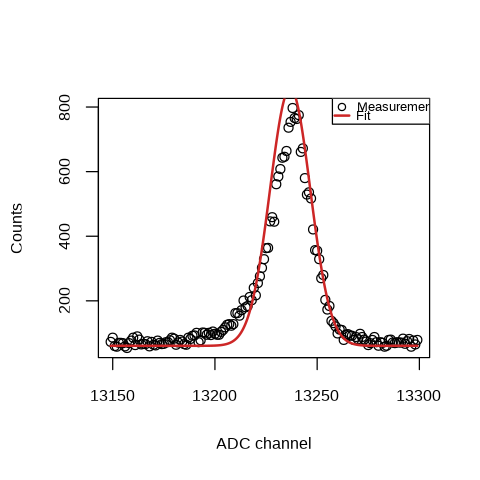

[1] "peak 15"
          mean        std     min_95      max_95
A  7084.945999 0.14188415 7084.67129 7085.226308
B    29.523329 0.19759997   29.12696   29.894426
w     9.350669 0.01730122    9.31687    9.384394
x0    9.350669 0.01730122    9.31687    9.384394


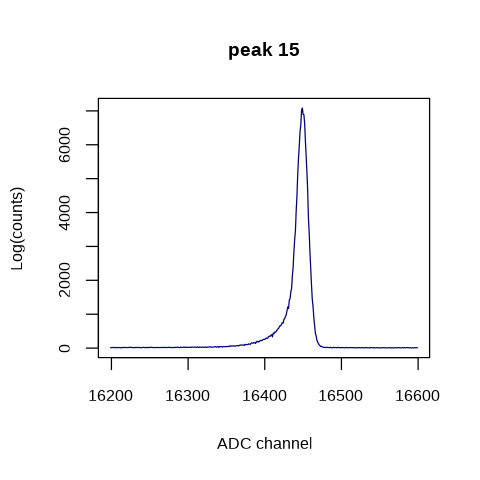

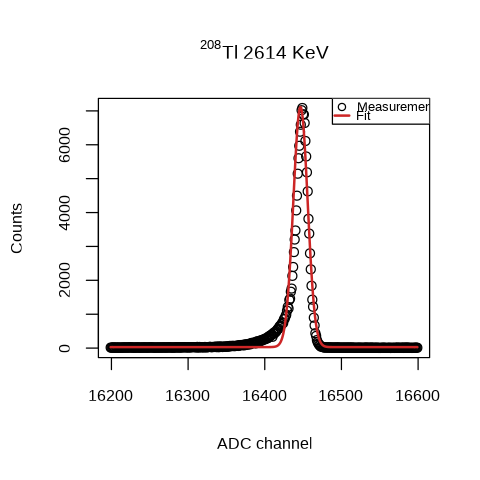

In [41]:
likelihood_str <- 'for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}'

priors_str <- function(A.min, A.max, B.max, x0.min, x0.max){
    priors_str <- paste("A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)", sep = '')
return(priors_str)
}

names <- c(TeX("^{212}Pb 238 KeV"),TeX("^{241}Pb 300 KeV"),
           TeX("^{208}Tl 510 KeV"),TeX("^{208}Tl 583 KeV"),TeX("^{212}Bi 727 KeV"),TeX("^{208}Tl 763 KeV"),TeX("^{212}Bi 785 KeV"),
           TeX("^{208}Tl 860 KeV"),TeX("^{212}Bi 893 KeV"),TeX("^{212}Bi 1078 KeV"),TeX("^{212}Bi 1512 KeV"),TeX("^{208}Tl 1592 KeV "),
           TeX("^{212}Bi 1620 KeV"),"",TeX("^{208}Tl 2614 KeV")          )
T_properties <- peak_properties(th_peaks, likelihood_str, priors_str,names)

## Energy calibration

In [42]:
df_T$x0_mean <- T_properties$x0_mean
df_T$x0_std  <- T_properties$x0_std
df_T$w_mean  <- T_properties$w_mean
df_T$w_std   <- T_properties$w_std

df_T

T_energies x0_mean   x0_std      w_mean   w_std      
Pb 1  238.632    1503.164 0.003010777 2.704313 0.001938908
Pb 2  300.089    1890.172 0.013881068 2.755689 0.009396985
Tl 1  510.740    3216.230 0.013444651 4.097722 0.008928485
Tl 2  583.187    3672.191 0.006952109 3.928637 0.004509703
Bi 1  727.330    4579.221 0.018132064 4.352159 0.011551840
Tl 3  763.450    4806.365 0.068349125 4.450150 0.048137411
Bi 2  785.370    4945.600 0.050619819 4.449739 0.036067610
Tl 4  860.530    5417.789 0.026413684 4.771975 0.016926113
Bi 3  893.408    5625.066 0.103002756 4.446919 0.072757402
Bi 4 1078.630    6791.421 0.098735444 4.910911 0.069074900
Bi 5 1512.700    9523.178 0.174192422 5.465889 0.128876809
Tl 5 1592.511   10025.994 0.081111853 5.131247 0.053483343
Bi 6 1620.738   10201.758 0.081393319 6.059664 0.055072250
Tl 6 2103.511   13236.794 0.095618925 9.860510 0.062190451
Tl 7 2614.511   16446.596 0.026683105 9.350669 0.017301216

In [43]:
linear_fit <- lm( df_T$T_energies ~ df_T$x0_mean )
summary(linear_fit)$coefficients

intercept     <- summary(linear_fit)$coefficients[1,1]
std_intercept <- summary(linear_fit)$coefficients[1,2]
slope         <- summary(linear_fit)$coefficients[2,1]
std_slope     <-  summary(linear_fit)$coefficients[2,2
                                              ]
#calibrated_energy <- function(x,a,b) a*x+b   

Estimate   Std. Error   t value     Pr(>|t|)    
(Intercept)  -0.6542059 1.754739e-01   -3.728222 2.530244e-03
df_T$x0_mean  0.1589606 2.209247e-05 7195.239994 2.726887e-44

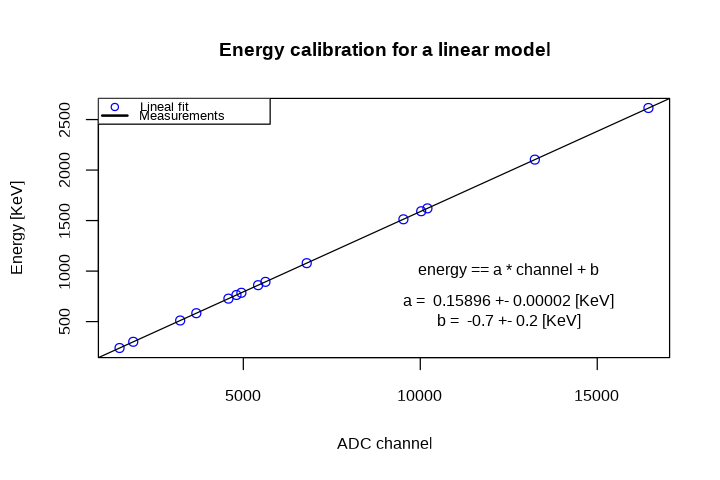

In [44]:
set_plot_dimensions(6, 4)
plot(df_T$x0_mean,df_T$T_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_T$Ch,calibrated_energy(data_T$Ch,slope,intercept))
#lines(data_T$Ch,calibrated_energy(data_T$Ch,slope+std_slope,intercept+std_intercept),col="red")
#lines(data_T$Ch,calibrated_energy(data_T$Ch,slope-std_slope,intercept-std_intercept),col="blue")

legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("blue","black"), lty=c(0,1),pch=c(1,-1),lwd=c(1,2), cex=0.8)

#text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(12500, 1000, "energy == a * channel + b")
text(12500, 700, paste("a = ", sprintf("%.5f",slope),"+-",sprintf("%.5f",std_slope),"[KeV]"))
text(12500, 500, paste("b = ", sprintf("%.1f",intercept),"+-",sprintf("%.1f",std_intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

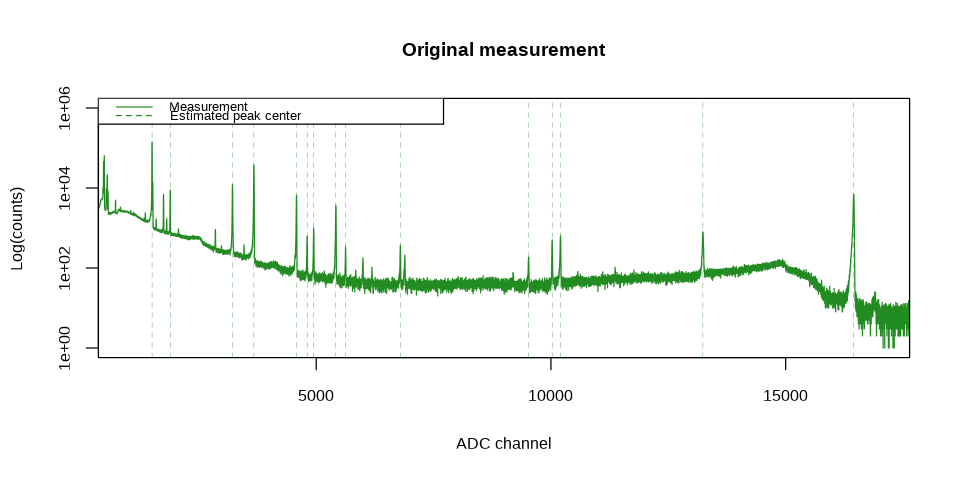

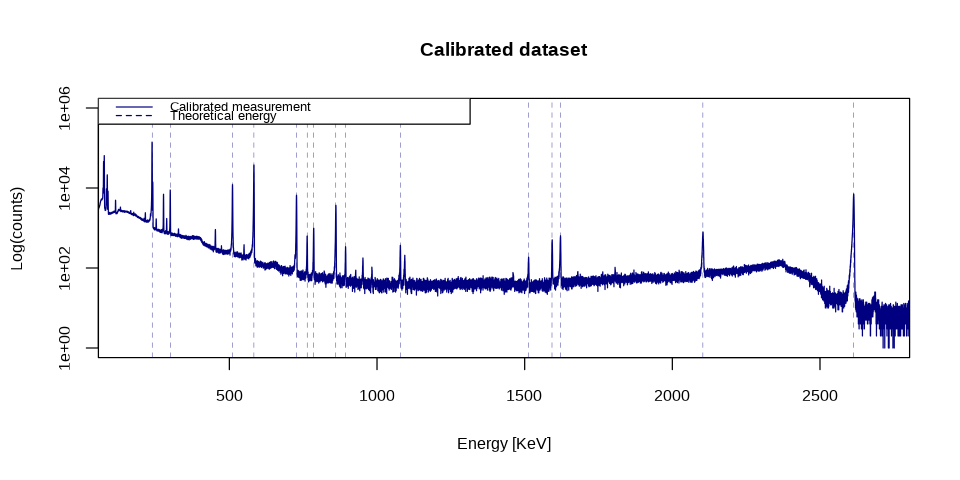

In [45]:
set_plot_dimensions(8, 4)

xmin<-1000;xmax<-17000
ymin<-1;ymax<-1000000
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    ylim=c(ymin,ymax),
    main = "Original measurement",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){
    abline(v=df_T$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}

legend("topleft", legend=c("Measurement","Estimated peak center"),
       col=c("forestgreen"), lty=1:2, cex=0.8)


plot(calibrated_energy(data_T$Ch,slope,intercept),data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    ylim=c(ymin,ymax),
    main = "Calibrated dataset",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:15){
    abline(v=df_T$T_energies[i],col="navy",lty=2,lwd=0.3)}
legend("topleft", legend=c("Calibrated measurement","Theoretical energy"),
       col=c("navy"), lty=1:2, cex=0.8)

## Resolution study

In [46]:
df_T

T_energies x0_mean   x0_std      w_mean   w_std      
Pb 1  238.632    1503.164 0.003010777 2.704313 0.001938908
Pb 2  300.089    1890.172 0.013881068 2.755689 0.009396985
Tl 1  510.740    3216.230 0.013444651 4.097722 0.008928485
Tl 2  583.187    3672.191 0.006952109 3.928637 0.004509703
Bi 1  727.330    4579.221 0.018132064 4.352159 0.011551840
Tl 3  763.450    4806.365 0.068349125 4.450150 0.048137411
Bi 2  785.370    4945.600 0.050619819 4.449739 0.036067610
Tl 4  860.530    5417.789 0.026413684 4.771975 0.016926113
Bi 3  893.408    5625.066 0.103002756 4.446919 0.072757402
Bi 4 1078.630    6791.421 0.098735444 4.910911 0.069074900
Bi 5 1512.700    9523.178 0.174192422 5.465889 0.128876809
Tl 5 1592.511   10025.994 0.081111853 5.131247 0.053483343
Bi 6 1620.738   10201.758 0.081393319 6.059664 0.055072250
Tl 6 2103.511   13236.794 0.095618925 9.860510 0.062190451
Tl 7 2614.511   16446.596 0.026683105 9.350669 0.017301216

In [47]:
#What we obtained from the peaks is w, the standard deviation of a normal distribution,
#this is related to the FWHM as 2*sqrt(2*log(2))*w

#This also needs to be converted to energy units (now is in channels)

df_T$FWHM_mean <- (2*sqrt(2*log(2))*T_properties$w_mean)*slope
df_T$FWHM_std <- (2*sqrt(2*log(2))*T_properties$w_std)*slope

In [48]:
df_Resolution_T <- NULL
df_Resolution_T$x <- df_T$T_energies[1:13]
df_Resolution_T$y <- df_T$FWHM_mean[1:13]

          mean         std      min_95      max_95
w  0.004222438 0.001440175 0.001602668 0.007103588
we 0.725240001 0.423258488 0.027669279 1.532959863


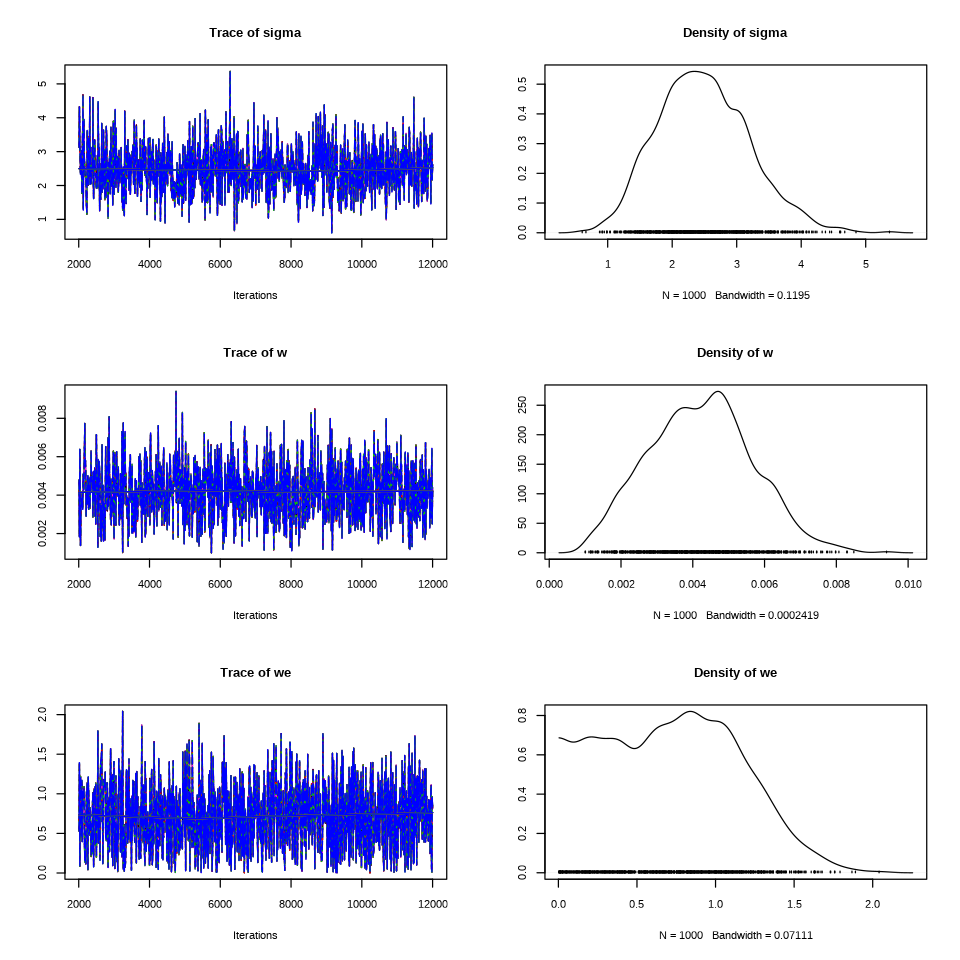

In [49]:
likelihood_res <- " 
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],sigma);
 
    } "
prior_res <-  "w ~ dunif(1.e-3,1);
    we ~ dunif(0,5)#dnorm(3,0.25);
    sigma ~ dnorm(0,1);
    #F ~dnorm(0.113,0.05)"
chain <- resolution(df_Resolution_T,likelihood_res,prior_res)


In [50]:
w      <- summary(chain)$statistics[2,1]; sw    <-  summary(chain)$statistics[2,2]
we     <- summary(chain)$statistics[3,1]; swe   <-  summary(chain)$statistics[3,2]
wmin   <- summary(chain)$quantiles[2,1];  wmax  <-  summary(chain)$quantiles[2,5]
wemin  <- summary(chain)$quantiles[3,1];  wemax <-  summary(chain)$quantiles[3,5]
print(paste(w,wmin,wmax))
print(paste(we,wemin,wemax))

[1] "0.00422243840071057 0.00160266825411742 0.0071035881462902"
[1] "0.725240000748707 0.0276692793088397 1.53295986323805"


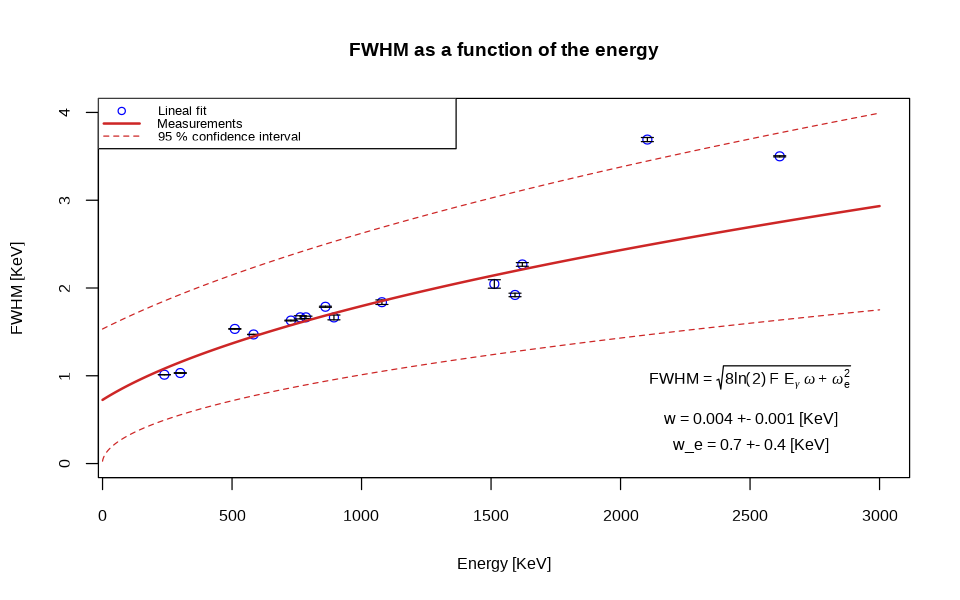

In [51]:
fano <-0.115
    
x <- seq(0,3000,1)
f <- function(x,w,we){return(sqrt(4*2*log(2) * fano * x * w + we**2))}
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 5)
plot(df_T$T_energies,df_T$FWHM_mean,col="blue",
    xlim=c(100,3000), ylim=c(0,4), 
    xlab="Energy [KeV]",ylab="FWHM [KeV]",
    main="FWHM as a function of the energy")

arrows(df_T$T_energies, df_T$FWHM_mean-df_T$FWHM_std,
       df_T$T_energies, df_T$FWHM_mean+df_T$FWHM_std,
       length=0.05, angle=90, code=3)

lines(x,f(x,w,we), lwd=2, col='firebrick3')
lines(x,f(x,wmin,wemin), lwd=1,lty=2, col='firebrick3')
lines(x,f(x,wmax,wemax), lwd=1,lty=2, col='firebrick3')

legend("topleft", legend=c("Lineal fit", "Measurements","95 % confidence interval"),
       col=c("blue","firebrick3","firebrick3"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2,1), cex=0.8)

#text(df_T$T_energies,df_T$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2500, 1,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2500, 0.5, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2500, 0.2, paste("w_e =", sprintf("%.1f",we),"+-",sprintf("%.1f",swe),"[KeV]"))